[Hamborg and Donnay, 2021] - "NewsMTSC: (Multi-)Target-dependent Sentiment Classification in News Articles"
- Authors: Felix Hamborg and Karsten Donnay
- Published in the Proceedings of the 16th Conference of the European Chapter of the Association for Computational Linguistics (EACL 2021)
- Year: 2021
- Month: April
- Location: Virtual Event

[Otmazgin et al., 2022] - "F-coref: Fast, Accurate and Easy to Use Coreference Resolution"
- Authors: Shon Otmazgin, Arie Cattan, and Yoav Goldberg
- Published in the Proceedings of AACL (Year: 2022)

[Otmazgin et al., 2022] - "LingMess: Linguistically Informed Multi Expert 
Scorers for Coreference Resolution"
- Authors: Shon Otmazgin, Arie Cattan, and Yoav Goldberg
- Published on arXiv, Year: 2022
- DOI: [10.48550/ARXIV.2205.12644](https://doi.org/10.48550/ARXIV.2205.12644)
- URL: [https://arxiv.org/abs/2205.12644](https://arxiv.org/abs/2205.12644)
- Keywords: Computation and Language (cs.CL), FOS: Computer and information sciences
- Copyright: Creative Commons Attribution 4.0 International



In [ ]:
# Python==3.8 (3.7.10 backup plan)

!pip install spacy
!pip install transformers
# Used for coreference resolution.
!pip install fastcoref    
# Used for finding overlapping intervals between sentence start and end 
# positions and mention positions within the text. 
!pip install intervaltree 
# Plotting exponential curves to investigate scaling.
!pip install matplotlib   
# Stops Target Dependent Sentimnet package downgrading pytorch which breaks MPS.
!pip install NewsSentiment --no-dependencies


In [ ]:
# !pip install psycopg2
!pip install --upgrade torch

# Database Setup

In [ ]:
'''Installed Postgres and ran following commands

CREATE DATABASE prominent_profiles;
CREATE USER python_access WITH PASSWORD 'XXXXXXXXX';
GRANT ALL PRIVILEGES ON DATABASE prominent_profiles TO python_access;
GRANT ALL PRIVILEGES ON SCHEMA public TO python_access;

'''

In [23]:
import psycopg2
import pandas as pd


class DatabaseManager:
    def __init__(self, host, database, user, password):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.conn = None
        self.close_on_error = False

    def connect(self):
        try:
            self.conn = psycopg2.connect(
                host=self.host,
                database=self.database,
                user=self.user,
                password=self.password
            )
        except psycopg2.Error as e:
            print("Error connecting to the database:", e)
            self.conn = None

    def create_entity_table(self):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        create_table_sql = """
            CREATE TABLE entity (
                id SERIAL PRIMARY KEY,
                source_article_id INT NOT NULL,
                name VARCHAR(50) NOT NULL,
                type VARCHAR(50)
            );
        """

        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'entity' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'entity' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()

    def create_article_table(self):
        if not self.conn:
            print("Database connection not established.")
            return
    
        cursor = self.conn.cursor()
    
        # Maybe I will consider adding sentences, word count, character to 
        # indicate relability, reading time etc to user.
        create_table_sql = """
            CREATE TABLE article (
                id SERIAL PRIMARY KEY,
                headline VARCHAR(255),
                url VARCHAR(255) NOT NULL,
                image_url VARCHAR(255),
                date_added TIMESTAMP NOT NULL
            );
        """
    
        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'article' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'article' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()
    
    def create_bound_mention_table(self):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        create_table_sql = """
            CREATE TABLE bound_mention (
                id SERIAL PRIMARY KEY,
                article_id INT NOT NULL,
                entity_id INT NOT NULL,
                bound_start INT NOT NULL,
                bound_end INT NOT NULL,
                avg_neutral NUMERIC,
                avg_positive NUMERIC,
                avg_negative NUMERIC,
                bound_text TEXT
            );
        """

        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'bound_mention' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'bound_mention' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()
                
                
    def create_overall_sentiment_table(self):
        if not self.conn:
            print("Database connection not established.")
            return
    
        cursor = self.conn.cursor()
    
        create_table_sql = """
            CREATE TABLE overall_sentiment (
                id SERIAL PRIMARY KEY,
                article_id INT NOT NULL,
                entity_id INT NOT NULL,
                num_bound INT NOT NULL,
                linear_neutral NUMERIC,
                linear_positive NUMERIC,
                linear_negative NUMERIC,
                exp_neutral NUMERIC,
                exp_positive NUMERIC,
                exp_negative NUMERIC
            );
        """
    
        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'overall_sentiment' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'overall_sentiment' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()            
    
    def insert_entity(self, entity_name, source_article_id=None):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        try:
            # Does entity already exist?
            cursor.execute("SELECT id FROM entity WHERE name = %s", 
                           (entity_name,))
            existing_entity = cursor.fetchone()
            
            if existing_entity is not None:
                # Return to prevent duplicate entity creation later
                return existing_entity[0]
            else:
                # Insert if entity does not exist (name match)
                print('inserting')
                cursor.execute("INSERT INTO entity (name, type, "
                               "source_article_id) VALUES (%s, NULL, %s)",
                               (entity_name, source_article_id))
                self.conn.commit()
                 # Get ID from the entity insert row
                cursor.execute("SELECT id FROM entity WHERE name = %s", (entity_name,))
                new_entity = cursor.fetchone()
                return new_entity[0]
        except Exception as e:
            print("Error:", e)
        finally:
            cursor.close()
    
    def close(self):
        if self.conn:
            self.conn.close()
            
    def insert_article(self, url, headline=None, image_url=None):
        if not self.conn:
            print("Database connection not established.")
            return None

        cursor = self.conn.cursor()
        
        try:
            # Does entity already exist?
            cursor.execute("SELECT id FROM article WHERE url = %s", (url,))
            existing_article = cursor.fetchone()

            if existing_article is not None:
            # Article already exists, return its ID  return existing_article[0]
            # Or actually just return -1 we don't need to analyse this URL
            # again 
            # (unless article was edited but that's not a concern right now)
                return -1
            else:
            # Insert the article if it doesn't exist
                cursor.execute("INSERT INTO article (headline, image_url, "
                               "url,  date_added) VALUES (%s, %s, %s, NOW()) "
                               " RETURNING id",
                           (headline, image_url, url))
                article_id = cursor.fetchone()[0]
                self.conn.commit()
                return article_id
        except Exception as e:
            print("Error:", e)
            return None
        finally:
            cursor.close()

            
    def display_table(self, table_name):
        if not self.conn:
            print("Database connection not established.")
            return
    
        try:
            query = f"SELECT * FROM {table_name};"
            df = pd.read_sql_query(query, self.conn)
            display(df)
        except Exception as e:
            print("Error:", e)

    def insert_bound_mention_data(self, entity_name, article_id, entity_db_id, 
                                   scores, text, bounds_keys):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        insert_data_sql = """
            INSERT INTO bound_mention (article_id, entity_id, bound_start, 
            bound_end, avg_neutral, avg_positive, avg_negative, bound_text)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
        """
        print(len(sentiment_scores))
        print(len(scores))
        print(len(bounds_keys))

        print(bounds_keys)
        article_id = article_id
        entity_id = entity_db_id
        bound_start = bounds_keys[0]
        bound_end = bounds_keys[1]
        avg_neutral = scores[0]
        avg_positive = scores[1]
        avg_negative = scores[2]
        bound_text = text

        data = (article_id, entity_id, bound_start, bound_end, avg_neutral, 
                avg_positive, avg_negative, bound_text)

        try:
            cursor.execute(insert_data_sql, data)
            self.conn.commit()
            print("Data inserted successfully for entity:", entity_name)
        except psycopg2.Error as e:
            self.conn.rollback()
            print(f"Error inserting data for entity {entity_name}:", e)

        cursor.close()
        
    def insert_overall_sentiment(self, article_id, entity_id, num_bound, linear_neutral, linear_positive, linear_negative, exp_neutral, exp_positive, exp_negative):
        if not self.conn:
            print("Database connection not established.")
            return
        
        cursor = self.conn.cursor()
        
        insert_data_sql = """
            INSERT INTO overall_sentiment (article_id, entity_id, num_bound, linear_neutral, linear_positive, linear_negative, exp_neutral, exp_positive, exp_negative)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
        """
        
        data = (article_id, entity_id, num_bound, linear_neutral, linear_positive, linear_negative, exp_neutral, exp_positive, exp_negative)
        
        try:
            cursor.execute(insert_data_sql, data)
            self.conn.commit()
            print("Data inserted successfully into 'overall_sentiment' table.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error inserting data into 'overall_sentiment' table:", e)
        finally:
            if self.close_on_error:
                cursor.close()
                self.conn.close()

In [79]:

    
    db_manager = DatabaseManager(
        host="localhost",
        database="prominent_profiles",
        user="python_access",
        password="LOCAL_USE_ONLY"
    )
    
    db_manager.connect()
    

In [86]:
db_manager.create_entity_table()
db_manager.create_article_table()
db_manager.create_bound_mention_table()
db_manager.create_overall_sentiment_table()

Error creating the 'entity' table: relation "entity" already exists

Error creating the 'article' table: relation "article" already exists

Error creating the 'bound_mention' table: relation "bound_mention" already exists

Table 'overall_sentiment' created successfully.


Attempting a fetch of a provided web page

# Article Fetching - Bing Search

Commented these out as 1000 tps free limit per month - extracted 

In [304]:
import os
%env BING_SEARCH_V7_SUBSCRIPTION_KEY= 262ba45387ce44259eb76a25d57ccbf6
subscription_key = os.environ['BING_SEARCH_V7_SUBSCRIPTION_KEY']

env: BING_SEARCH_V7_SUBSCRIPTION_KEY=262ba45387ce44259eb76a25d57ccbf6


In [15]:
# import requests
# search_term = "uk politics"
# search_url = "https://api.bing.microsoft.com/v7.0/news/search"
# freshness = "week"
# market = "en-UK"
# content_type = "news"
# 
# # headers = {"Ocp-Apim-Subscription-Key": subscription_key}
# # params = {
# #     "q": search_term,
# #     "count": 5,
# #     "freshness": freshness,
# #     "mkt": market,
# #     "textDecorations": True,
# #     "responseFilter": content_type,
# #     "textFormat": "HTML",
# # }
# 
# search_term = "uk politics"
# search_url = "https://api.bing.microsoft.com/v7.0/news/search"
# freshness = "week"
# market = "en-GB"
# content_type = "news"
# 
# headers = {"Ocp-Apim-Subscription-Key": subscription_key}
# params = {
#     "q": search_term,
#     "count": 50,
#     "freshness": freshness,
#     "textDecorations": True,
#     "responseFilter": content_type,
#     "textFormat": "HTML",
# }
# 
# response = requests.get(search_url, headers=headers, params=params)
# response.raise_for_status()
# search_results = response.json()
# 
# # Extract URLs, titles, and descriptions
# articles = search_results.get("value", [])
# urls = [article["url"] for article in articles]
# titles = [article["name"] for article in articles]
# descriptions = [article["description"] for article in articles]
# 
# print("URLs:")
# for url in urls:
#     print(url)
# 
# print("\nTitles:")
# for title in titles:
#     print(title)
# 
# print("\nDescriptions:")
# for desc in descriptions:
#     print(desc)
# 
# 
# response = requests.get(search_url, headers=headers, params=params)
# response.raise_for_status()
# search_results = response.json()

URLs:
https://www.theguardian.com/politics/live/2023/nov/08/labour-keir-starmer-imran-hussain-conservatives-rishi-sunak-israel-gaza-uk-politics?filterKeyEvents=false&page=with:block-654bc96a8f081362db4f986a
https://www.theguardian.com/politics/live/2023/nov/08/labour-keir-starmer-imran-hussain-conservatives-rishi-sunak-israel-gaza-uk-politics?filterKeyEvents=false&page=with:block-654bc0c48f08098a8706f8c6
https://www.express.co.uk/news/politics/1832697/kings-speech-labour-party-slap-down-tory-mp
https://www.express.co.uk/news/politics/1832631/rishi-sunak-keir-starmer-eu-plot
https://www.msn.com/en-gb/news/other/uk-politics-live-boris-claims-sunak-refused-to-engage-post-covid-because-he-wanted-to-be-pm/ar-AA1jtx7b
https://uk.style.yahoo.com/portugals-political-crisis-stalls-key-191413103.html
https://news.sky.com/story/politics-latest-top-civil-servant-who-made-chickenpox-parties-claim-set-to-face-covid-inquiry-labour-frontbencher-quits-over-gaza-stance-12593360?postid=6735968
https://ne

In [18]:
# # Save articles to a JSON file
# with open("articles.json", "w") as articles_file:
#     json.dump(articles, articles_file, indent=4)
# 
# # Save search results to a JSON file
# with open("search_results.json", "w") as results_file:
#     json.dump(search_results, results_file, indent=4)
# 
# print("Articles and search results saved to files.")

Articles and search results saved to files.


In [11]:
print(search_results)

{'_type': 'News', 'readLink': 'https://api.bing.microsoft.com/api/v7/news/search?q=uk+politics', 'queryContext': {'originalQuery': 'uk politics', 'adultIntent': False}, 'totalEstimatedMatches': 42, 'sort': [{'name': 'Best match', 'id': 'relevance', 'isSelected': True, 'url': 'https://api.bing.microsoft.com/api/v7/news/search?q=uk+politics'}, {'name': 'Most recent', 'id': 'date', 'isSelected': False, 'url': 'https://api.bing.microsoft.com/api/v7/news/search?q=uk+politics&sortby=date'}], 'value': [{'name': 'Rishi Sunak says pro-Palestine march on Saturday is ‘proof of <b>UK</b>’s commitment to freedom’ – <b>UK politics</b> live', 'url': 'https://www.theguardian.com/politics/live/2023/nov/08/labour-keir-starmer-imran-hussain-conservatives-rishi-sunak-israel-gaza-uk-politics?filterKeyEvents=false&page=with:block-654bc96a8f081362db4f986a', 'image': {'thumbnail': {'contentUrl': 'https://www.bing.com/th?id=OVFT.fQC1YtW87El7uCe0U5NvCy&pid=News', 'width': 700, 'height': 367}}, 'description': 'P

In [12]:
# # Extract URLs, titles, and descriptions
# articles = search_results.get("value", [])
# urls = [article["url"] for article in articles]
# titles = [article["name"] for article in articles]
# descriptions = [article["description"] for article in articles]
# 
# print("URLs:")
# for url in urls:
#     print(url)
# 
# print("\nTitles:")
# for title in titles:
#     print(title)
# 
# print("\nDescriptions:")
# for desc in descriptions:
#     print(desc)

URLs:
https://www.theguardian.com/politics/live/2023/nov/08/labour-keir-starmer-imran-hussain-conservatives-rishi-sunak-israel-gaza-uk-politics?filterKeyEvents=false&page=with:block-654bc96a8f081362db4f986a
https://www.theguardian.com/politics/live/2023/nov/08/labour-keir-starmer-imran-hussain-conservatives-rishi-sunak-israel-gaza-uk-politics?filterKeyEvents=false&page=with:block-654bc0c48f08098a8706f8c6
https://www.express.co.uk/news/politics/1832697/kings-speech-labour-party-slap-down-tory-mp
https://www.express.co.uk/news/politics/1832631/rishi-sunak-keir-starmer-eu-plot
https://www.msn.com/en-gb/news/other/uk-politics-live-boris-claims-sunak-refused-to-engage-post-covid-because-he-wanted-to-be-pm/ar-AA1jtx7b

Titles:
Rishi Sunak says pro-Palestine march on Saturday is ‘proof of <b>UK</b>’s commitment to freedom’ – <b>UK politics</b> live
Ex-civil service head joked about need to sack Hancock ‘to protect NHS’, inquiry hears – <b>UK politics</b> live
Commons erupts at Tory MP&#39;s b

## Improved no duplicate pull (daily)

In [28]:
'''I found that BING NEWS API can struggle with pagination (backed by online threads) so it 
doesn't provide the hundreads of articles I'd like even when the scope is set to 'week' or 
'month' -> I propose daily pulls with the 'day' filter and then overtime a collection of urls will
 take place and my database of articles, entites and sentiments will expand overtime.
 
 As long as only one pull takes place a day there should in theory not be cross over / 
 duplication of articles - although the database will handle this by URL.'''


import requests
import json
import time
from datetime import datetime

# Daily download for entities.

# search_term = "rishi sunak"
# search_term = "keir starmer"
search_term = "uk politics"
search_url = "https://api.bing.microsoft.com/v7.0/news/search"

headers = {"Ocp-Apim-Subscription-Key": subscription_key}
results_to_fetch = 500 # Set the number of articles to fetch
count = 100  # Number of articles to fetch per request
articles = []  # Array to store articles
search_results_list = []  # List to store search results

duplicate_urls = set()
duplicate_count = 0
max_duplicate_count = 25  # Stop if duplicate count exceeds this limit


skip_future_calls = False

for offset in range(0, results_to_fetch, count):
    if skip_future_calls:
        break
        
    time.sleep(1)  # Adding a 1-second delay to avoid rate limiting.
    params = {
        "q": search_term,
        "count": count,
        "offset": offset,
        "freshness": "day",
        "textDecorations": True,
        "textFormat": "HTML",
        "sortBy": "Date"
    }

    print(params)
    try:
        response = requests.get(search_url, headers=headers, params=params)
        response.raise_for_status()
        search_results = response.json()
        search_results_list.append(search_results)

        if "value" in search_results:
            i = 0
            for article in search_results["value"]:
                i += 1
                print(i)
                url = article["url"]

                # Exclude articles that start with "https://www.msn.com"
                if not url.startswith("https://www.msn.com"):
                    # Check for duplicate URLs
                    if url in duplicate_urls:
                        duplicate_count += 1
                        if duplicate_count >= max_duplicate_count:
                            print(f"Stopping due to {max_duplicate_count} or more duplicate URLs.")
                            skip_future_calls = True
                    else:
                        duplicate_urls.add(url)
                        duplicate_count = 0  # Reset duplicate count

                        title = article["name"]
                        description = article["description"]
                        articles.append({"url": url, "title": title, "description": description})
        else:
            print("No search results found.")
    except requests.exceptions.HTTPError as e:
        print(f"HTTPError: {e.response.status_code} - {e.response.text}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


for i, article in enumerate(articles):
    print(f"Article {i + 1}:")
    print("URL:", article["url"])
    print("Title:", article["title"])
   # print("Description:", article["description"])
    print()



formatted_search_term = search_term.replace(" ", "+")
timestamp = datetime.now().strftime("%d-%m-%Y-%H:%M")
articles_filename = f"{formatted_search_term}_no_dup_articles_loop_{timestamp}.json"
results_filename = f"{formatted_search_term}_no_dup_results_loop_{timestamp}.json"

# Save articles to a JSON file
with open(articles_filename, "w") as articles_file:
    json.dump(articles, articles_file, indent=4)

# Save search results to a JSON file
with open(results_filename, "w") as results_file:
    json.dump(search_results_list, results_file, indent=4)

print("Articles and search results saved to files.")

{'q': 'uk politics', 'count': 100, 'offset': 0, 'freshness': 'day', 'textDecorations': True, 'textFormat': 'HTML', 'sortBy': 'Date'}
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
{'q': 'uk politics', 'count': 100, 'offset': 100, 'freshness': 'day', 'textDecorations': True, 'textFormat': 'HTML', 'sortBy': 'Date'}
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
{'q': 'uk politics', 'count': 100, 'offset': 200, 'freshness': 'day', 'textDecorations': True, 'textFormat': 'HTML', 'sortBy': 'Date'}
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
Stopping due to 25 or more duplicate URLs.
28
Stopping due to 25 or more duplicate URLs.
29
Stopping due to 25 or more duplicate URLs.
30
Stopping due to 25 or more duplicate URLs.
31
Stopping due to 25 or more duplicate URLs.
32
Stopping due to 25 or more duplicate URLs.
33
Stopping due to 25 or more duplicate URLs.
34
Stopping due to 25 or more duplicate URLs.
35
Stopping due to 25 

In [20]:
# articles = {}
# search_results = None

In [30]:
# import requests
# import json
# import time
# 
# search_term = "uk politics"
# search_url = "https://api.bing.microsoft.com/v7.0/news/search"
# freshness = "week"
# market = "en-GB"
# content_type = "news"
# 
# 
# headers = {"Ocp-Apim-Subscription-Key": subscription_key}
# results_to_fetch = 250  # Set the number of articles to fetch
# count = 50 # Number of articles to fetch per request
# articles = []  # Array to store articles
# search_results_list = []  # List to store search results
# 
# for offset in range(0, results_to_fetch, count):
#     time.sleep(1)  # Adding a 1-second delay to avoid rate limiting.
#     params = {
#         "q": search_term,
#         "count": count,
#         "offset": offset,
#         "freshness": "week",
#         "textDecorations": True,
#         "responseFilter": "news",
#         "textFormat": "HTML",
#     }
# 
#     print(params)
#     try:
#         response = requests.get(search_url, headers=headers, params=params)
#         response.raise_for_status()
#         search_results = response.json()
#         search_results_list.append(search_results)
# 
#         if "value" in search_results:
#             for article in search_results["value"]:
#                 url = article["url"]
#                 title = article["name"]
#                 description = article["description"]
#                 articles.append({"url": url, "title": title, "description": description})
#         else:
#             print("No search results found.")
#     except requests.exceptions.HTTPError as e:
#         print(f"HTTPError: {e.response.status_code} - {e.response.text}")
#     except Exception as e:
#         print(f"An error occurred: {str(e)}")
# 
# 
# 
# for i, article in enumerate(articles):
#     print(f"Article {i + 1}:")
#     print("URL:", article["url"])
#     print("Title:", article["title"])
#    # print("Description:", article["description"])
#     print()
# 
# 
# # Save articles to a JSON file
# with open("articles_loop_results.json", "w") as articles_file:
#     json.dump(articles, articles_file, indent=4)
# 
# # Save search results to a JSON file
# with open("search_results_loop_results.json", "w") as results_file:
#     json.dump(search_results_list, results_file, indent=4)
# 
# print("Articles and search results saved to files.")


{'q': 'uk politics', 'count': 50, 'offset': 0, 'freshness': 'week', 'textDecorations': True, 'responseFilter': 'news', 'textFormat': 'HTML'}
{'q': 'uk politics', 'count': 50, 'offset': 50, 'freshness': 'week', 'textDecorations': True, 'responseFilter': 'news', 'textFormat': 'HTML'}
{'q': 'uk politics', 'count': 50, 'offset': 100, 'freshness': 'week', 'textDecorations': True, 'responseFilter': 'news', 'textFormat': 'HTML'}
{'q': 'uk politics', 'count': 50, 'offset': 150, 'freshness': 'week', 'textDecorations': True, 'responseFilter': 'news', 'textFormat': 'HTML'}
{'q': 'uk politics', 'count': 50, 'offset': 200, 'freshness': 'week', 'textDecorations': True, 'responseFilter': 'news', 'textFormat': 'HTML'}
Article 1:
URL: https://www.theguardian.com/politics/live/2023/nov/08/labour-keir-starmer-imran-hussain-conservatives-rishi-sunak-israel-gaza-uk-politics?filterKeyEvents=false&page=with:block-654bc96a8f081362db4f986a
Title: Rishi Sunak says pro-Palestine march on Saturday is ‘proof of <b

# Aritcle Fetching - Original One Offs

In [5]:
# import trafilatura
# downloaded = trafilatura.fetch_url('https://github.blog/2019-03-29-leader-spotlight-erin-spiceland/')
# trafilatura.extract(downloaded)

'Leveraging AI to empower all developers at GitHub Universe 2023\nGitHub Universe 2023 is just around the corner! Join us and learn how GitHub is leveraging AI to empower all developers, including developers with disabilities.\nWe’re spending Women’s History Month with women leaders who are making history every day in the tech community. Read more about Erin Spiceland: Software Engineer at SpaceX.\nEvery March we recognize the women who have shaped history—and now, we’re taking a look forward. From driving software development in large companies to maintaining thriving open source communities, we’re spending Women’s History Month with women leaders who are making history every day in the tech community. Erin Spiceland is a Software Engineer for SpaceX. Born and raised in rural south Georgia, she is a Choctaw and Chickasaw mother of two now living in downtown Los Angeles. Erin didn’t finish college—she’s a predominantly self-taught software engineer. In her spare time, she makes handmad

Attempting a fetch of URLs from an RSS (Really Simple Syndication) feed 

In [6]:
from trafilatura import feeds
mylist = feeds.find_feed_urls('https://www.dailymail.co.uk/news/rishi-sunak/index.rss') 
# mylist = feeds.find_feed_urls('https://www.dailymail.co.uk/news/uk-politics/index.rss')
print(mylist)

['https://www.dailymail.co.uk/?ito=1490&ns_campaign=1490&ns_mchannel=rss', 'https://www.dailymail.co.uk/columnists/article-12721059/Rishi-Sunak-pledges-brighter-future-Britain-King-Speech.html?ito=1490&ns_campaign=1490&ns_mchannel=rss', 'https://www.dailymail.co.uk/debate/article-12672813/STEPHEN-GLOVER-rocket-Jeremy-Hunt-doesnt-promise-tax-cuts-Tories-finished.html?ito=1490&ns_campaign=1490&ns_mchannel=rss', 'https://www.dailymail.co.uk/debate/article-12677181/QUENTIN-LETTS-Sunaks-gaze-framed-begging-dog-eyebrows-told-AI-herald-mankinds-obliteration.html?ito=1490&ns_campaign=1490&ns_mchannel=rss', 'https://www.dailymail.co.uk/debate/article-12678233/Banning-China-UKs-AI-summit-make-no-sense-writes-former-head-GCHQs-national-security-centre-CIARAN-MARTIN.html?ito=1490&ns_campaign=1490&ns_mchannel=rss', 'https://www.dailymail.co.uk/debate/article-12704993/ALEX-BRUMMER-Bank-Englands-gloomy-forecast-2024-pinch-salt.html?ito=1490&ns_campaign=1490&ns_mchannel=rss', 'https://www.dailymail.co

# Article Fetching - Titles and Images

In [4]:
'''
If article is being added to database get the 'headline' - title of html /  
what appears in your browser tab for now'
'''
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests

def get_article_title(url):
    html_page = urlopen(url)
    soup = BeautifulSoup(html_page, 'html.parser')
    return soup.title.string


def get_preview_image_url(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Open Graph image tag attempt
            og_image = soup.find('meta', property='og:image')
            if og_image:
                return og_image['content']

            # Otherwie, look for Twitter Card image tag
            twitter_image = soup.find('meta', name='twitter:image')
            if twitter_image:
                return twitter_image['content']

        else:
            return "Error fetching URL"

    except Exception as e:
        print("Error:", e)
        return "Error fetching URL"


# print(get_article_title("https://www.theguardian.com/commentisfree/2023/nov/07/nadine-dorries-book-dead-cat-conservatives"))
# print(get_preview_image_url("https://www.theguardian.com/commentisfree/2023/nov/07/nadine-dorries-book-dead-cat-conservatives"))
# print(get_article_title('https://www.dailymail.co.uk/news/article-12350195/Think-twice-imposing-Ulez-tax-hard-working-Brits-Rishi-Sunak-blasts-Sadiq-Khan-hated-low-emission-zone-expansion-plan.html?ns_mchannel=rss&ns_campaign=1490&ito=1490'))
# print(get_preview_image_url('https://www.dailymail.co.uk/news/article-12350195/Think-twice-imposing-Ulez-tax-hard-working-Brits-Rishi-Sunak-blasts-Sadiq-Khan-hated-low-emission-zone-expansion-plan.html?ns_mchannel=rss&ns_campaign=1490&ito=1490'))

What’s in Nadine Dorries’s book? A pile of dead cats big enough to kill that phrase for good | Marina Hyde | The Guardian
https://i.guim.co.uk/img/media/a30ade74705787f1166f39b405f0c0f4cc794fbc/0_0_3486_2092/master/3486.jpg?width=1200&height=630&quality=85&auto=format&fit=crop&overlay-align=bottom%2Cleft&overlay-width=100p&overlay-base64=L2ltZy9zdGF0aWMvb3ZlcmxheXMvdGctb3BpbmlvbnMucG5n&enable=upscale&s=cb6f1a43f33b02addb851ad06197cb81
'Think twice before imposing Ulez tax on hard-working Brits': Rishi Sunak blasts Sadiq Khan for his hated low emission zone expansion plan | Daily Mail Online
https://i.dailymail.co.uk/1s/2023/07/28/21/73733883-0-image-a-24_1690576944121.jpg


https://adrien.barbaresi.eu/blog/how-to-download-parallel-politeness-rules-python.html
Provides a method to check the robot txt of a site and check if the url being extracted meets the politeness policy.

When extracting from bing check for each domain and store in data structure with allow/disallow. If the same base url appears again then no need to recheck robot.txt

In [56]:
for i, article in enumerate(articles):
    url = article["url"]
    title = article["title"]
    description = article["description"]

    can_fetch = can_fetch_url(url)

    if not can_fetch:
        print(f"Article {i + 1}:")
        print("URL:", url)
        print("Title:", title)
        # print("Description:", description)
        print("Can Fetch:", can_fetch)
        print()

https://www.theguardian.com
https://www.theguardian.com
https://www.express.co.uk
https://uk.news.yahoo.com
https://www.express.co.uk
https://www.ft.com
https://www.msn.com
https://uk.sports.yahoo.com
https://uk.news.yahoo.com
https://uk.style.yahoo.com
https://news.sky.com
https://www.politicshome.com
https://www.msn.com
https://bylinetimes.com
https://www.msn.com
https://www.newstatesman.com
https://inews.co.uk
https://www.msn.com
https://uk.movies.yahoo.com
https://www.bbc.com
https://www.middleeasteye.net
Article 21:
URL: https://www.middleeasteye.net/opinion/uk-robin-simcox-government-found-cheerleader-own-brand-extremism
Title: Robin Simcox: A cheerleader for the <b>UK</b> government&#39;s own brand of extremism
Can Fetch: False

https://www.bbc.co.uk
https://bylinetimes.com
https://www.derrynow.com
https://uk.movies.yahoo.com
https://www.thetimes.co.uk
https://www.ft.com
https://www.heraldscotland.com
https://www.politico.eu
Article 29:
URL: https://www.politico.eu/article/brita

In [8]:
# downloaded = trafilatura.fetch_url(mylist[6])
# trafilatura.extract(downloaded, favour_precision=True, 
#                     include_comments=False,  include_images=False,  
#                     include_tables=False)

"DAN HODGES: The war in Israel could have been a disaster for Keir. Instead it's been the making of him\nThe 100 or so protesters outside Downing Street on Wednesday evening claimed to be championing a ceasefire in Gaza. But their chants betrayed them. ‘Palestine will be free, from the river to the sea!’ they shouted, invoking a slogan that advocates the complete eradication of the Jewish homeland.\n‘No justice, no peace!’ was another favourite. ‘Let’s make it louder!’, the group’s leader bellowed through her megaphone in a North American accent. ‘We need to make sure Rishi Sunak hears us!’\nWhether the Prime Minister, inside meeting US Vice-President Kamala Harris, did hear them was unclear. But one senior political leader certainly wasn’t heeding their calls.\nA day earlier, Sir Keir Starmer had spoken at Chatham House to address the Hamas-Israel war. His speech was delivered against a backdrop of spiralling unrest within his party.\nMembers of Labour’s ruling NEC had accused Israel 

Consider when implementing News Article fetch adding politeness / adherence to robot policy.

In [4]:
'''Determine if the URL can be fetched by all crawlers - adding politeness / adherence to robot policy.'''

from urllib.parse import urlparse
import urllib.robotparser

def can_fetch_url(url_to_check):
    parsed_url = urlparse(url_to_check)
    base_url = parsed_url.scheme + "://" + parsed_url.netloc
    print(base_url)
    rules = urllib.robotparser.RobotFileParser()
    rules.set_url(base_url + "/robots.txt")
    rules.read()
    return rules.can_fetch("*", url_to_check)

In [7]:
import urllib.robotparser

# define a website to look for rules
base_url = "https://www.theguardian.com"

# load the necessary components, fetch and parse the file
rules = urllib.robotparser.RobotFileParser()
rules.set_url(base_url + "/robots.txt")
rules.read()

print(rules)

# determine if a page can be fetched by all crawlers
rules.can_fetch("*", "https://www.theguardian.com/import urllib.robotparser")
# returns True or False

User-agent: Mediapartners-Google
Allow: 

User-agent: NewsNow
Disallow: /

User-agent: GPTBot
Disallow: /

User-agent: CCBot
Disallow: /

User-agent: TurnitinBot
Disallow: /

User-agent: PetalBot
Disallow: /

User-agent: MoodleBot
Disallow: /

User-agent: *
Disallow: /sendarticle/
Disallow: /Users/
Disallow: /users/
Disallow: /%2A/print%24
Disallow: /email/
Disallow: /contactus/
Disallow: /share/
Disallow: /websearch
Disallow: /%2A%3Fcommentpage%3D
Disallow: /whsmiths/
Disallow: /external/overture/
Disallow: /discussion/report-abuse/%2A
Disallow: /discussion/report-abuse-ajax/%2A
Disallow: /discussion/comment-permalink/%2A
Disallow: /discussion/report-abuse/%2A
Disallow: /discussion/user-report-abuse/%2A
Disallow: /discussion/handlers/%2A
Disallow: /discussion/your-profile
Disallow: /discussion/your-comments
Disallow: /discussion/edit-profile
Disallow: /discussion/search/comments
Disallow: /discussion/%2A
Disallow: /search
Disallow: /music/artist/%2A
Disallow: /music/album/%2A
Disallow

True

Extraction from 1 article from the RSS list and setting some extra parameters in Trafilatura.

In [9]:
'''Article is saved as text file anyway'''

article_url = 'https://www.dailymail.co.uk/news/article-12350195/Think-twice-imposing-Ulez-tax-hard-working-Brits-Rishi-Sunak-blasts-Sadiq-Khan-hated-low-emission-zone-expansion-plan.html?ns_mchannel=rss&ns_campaign=1490&ito=1490'

# downloaded = trafilatura.fetch_url('https://www.dailymail.co.uk/news/article-12350195/Think-twice-imposing-Ulez-tax-hard-working-Brits-Rishi-Sunak-blasts-Sadiq-Khan-hated-low-emission-zone-expansion-plan.html?ns_mchannel=rss&ns_campaign=1490&ito=1490')
# article_text = trafilatura.extract(downloaded)

Saving article to file - useful for demo/consistent experimental purposes - if article is deleted or edited my copy will stay the same.

In [10]:
# file_path = "ULEZ-daily-mail-research-article.txt"
# 
# # Write the text to the file
# with open(file_path, 'w', encoding='utf-8') as file:
#     file.write(article_text)
# 
# print(f"Article text saved to {file_path}")

In [11]:
file_path = "ULEZ-daily-mail-research-article.txt"

# Read the text from the file
with open(file_path, 'r', encoding='utf-8') as file:
    article_text = file.read()

# Now, article_text contains the text you read from the file
print(f"Article text read from {file_path}:\n{article_text}")    

Article text read from ULEZ-daily-mail-research-article.txt:
'Think twice before imposing Ulez tax on hard-working Brits': Rishi Sunak blasts Sadiq Khan for his hated low emission zone expansion plan
- Keir Starmer told to 'get off the fence' over Sadiq Khan's Ulez by senior Tory MPs
- Rishi Sunak led MPs asking Starmer to get London mayor to postpone the levy
- READ MORE: Labour civil war over ULEZ intensifies after Khan's High Court win
Keir Starmer faced fresh calls last night for him to try to delay the expansion of London's clean air zone.
Senior Tories said he should 'get off the fence' and force the capital's mayor Sadiq Khan to protect motorists set to pay the Ulez levy.
The High Court yesterday backed the extension of Ulez into outer London – a move that could lead to similar schemes elsewhere in Britain.
Sir Keir has refused to say whether the zone should expand, claiming it is not a 'simple political decision'. He remained silent after yesterday's court ruling.
Rishi Sunak l

In [12]:
import torch
import spacy

In [55]:
print(can_fetch_url("https://www.theguardian"
               ".com/politics/live/2023/nov/08/labour-keir-starmer-imran-hussain-conservatives"
                    "-rishi-sunak-israel-gaza-uk-politics?page=with:block-654bc96a8f081362db4f986a"))


can_fetch_url("https://www.theguardian.com/politics/live/2023/nov/08/labour-keir-starmer-imran-hussain-conservatives-rishi-sunak-israel-gaza-uk-politics?filterKeyEvents=false&page=with:block-654bc0c48f08098a8706f8c6")

https://www.theguardian.com
True
https://www.theguardian.com


True

In [13]:
print(torch.__version__)

2.1.0


In [14]:
# Check Metal Performance Shaders (MPS) backend for GPU training acceleration.
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [15]:
from fastcoref import FCoref

model = FCoref(device='mps') # MPS aten:cumsum.out sometimes on M1 MAC.

preds = model.predict(
   texts=['We are so happy to see you using our coref package. This package is very fast!']
)

preds[0].get_clusters(as_strings=False)


print(preds[0].get_clusters())


preds[0].get_logit(
   span_i=(33, 50), span_j=(52, 64)
)


11/08/2023 17:55:59 - INFO - 	 missing_keys: []
11/08/2023 17:55:59 - INFO - 	 unexpected_keys: []
11/08/2023 17:55:59 - INFO - 	 mismatched_keys: []
11/08/2023 17:55:59 - INFO - 	 error_msgs: []
11/08/2023 17:55:59 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M
11/08/2023 17:55:59 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

11/08/2023 17:55:59 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/ameek/anaconda3/envs/Project/lib/python3.8/site-packages/fastcoref/coref_models/modeling_fcoref.py:91: UserWarning: MPS: no support for int64 for sum_out_mps, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:155.)
  actual_seq_lengths = torch.sum(attention_mask, dim=-1)  # [batch_size]
/Users/ameek/anaconda3/envs/Project/lib/python3.8/site-packages/fastcoref/coref_models/modeling_fcoref.py:103: UserWarning: MPS: no support for int64 for sort_stable_out, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Sort.mm:30.)
  sorted_topk_1d_indices, _ = torch.sort(topk_1d_indices, dim=-1)  # [batch_size, max_k]


[['We', 'our'], ['our coref package', 'This package']]


18.852913

Playing around with extracting coreference clusters using fastcoref directly
"Processing can be applied to a collection of texts of any length in a batched and parallel fashion"
https://pypi.org/project/fastcoref/

In [16]:
'''
I am performing coreference resolution using fastcoref on a given text and 
then analysing and printing information about the resolved coreference clusters. 
This helps me identify and understand how words or phrases in the text refer 
to  the same entities, and I am prioritising clusters based on their text 
content length.

Sorted_combined_clusters will be used later with the NER resulted from spaCy.
'''



from fastcoref import FCoref

model = FCoref(device='mps')

preds = model.predict(
   texts=[article_text]
)

clustersText = preds[0].get_clusters()
clustersPositions = preds[0].get_clusters(as_strings=False)

print(clustersText)

combined_clusters = [(text, positions, len(text)) for text, positions in zip
(clustersText, clustersPositions)]

sorted_combined_clusters = sorted(combined_clusters, key=lambda x: x[2], 
                                  reverse=True)

for i, (clusterText, clusterPos, cluster_text_count) in (enumerate
    (sorted_combined_clusters, 1)):
    print(f"Cluster {i} : {clusterText}")
    print(f"Cluster Text Count: {cluster_text_count}")
    print("Positions:", clusterPos)


11/08/2023 17:56:01 - INFO - 	 missing_keys: []
11/08/2023 17:56:01 - INFO - 	 unexpected_keys: []
11/08/2023 17:56:01 - INFO - 	 mismatched_keys: []
11/08/2023 17:56:01 - INFO - 	 error_msgs: []
11/08/2023 17:56:01 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M
11/08/2023 17:56:01 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

11/08/2023 17:56:01 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

[['Sadiq Khan', 'his', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'I', 'I', 'Mr Khan', 'Sadiq', 'He', 'he', 'his', 'he', 'your mayor', 'the Labour mayor', 'his', "Mr Khan's", "the mayor's", 'his', 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"], ['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)'], ['Keir Starmer', 'Starmer', 'Keir Starmer', 'him', 'he', 'Sir Keir', 'He', 'the Labour leader', 'Keir Starmer (left)', 'him', 'the Labour leader', "Sir Keir Starmer's", 'Starmer', 'Sir Keir', 'the Labour leader', 'Keir', 'he', 'Sir Keir', 'Sir Keir'], ["Sadiq Khan's Ulez", 'ULEZ', 'ULEZ'], ['London', "London's", "the capital's", 'London', "London's", 'London', 'London', "London's", 'London', "London's", 'London'], ['the levy', 'the Ulez levy', 'the £12.50 daily levy for older, more polluting vehicles', 'it', 'the £12.50 dai

LingMess Coref - alternative state-of-the-art coreference resolution but doesn't want to play with my M1 Mac GPU so have to fall back to slower CPU device :(

In [17]:
from fastcoref import LingMessCoref

model = LingMessCoref(device='cpu')

preds = model.predict(
   texts=[article_text]
)

print(preds[0].get_clusters()) 

11/08/2023 17:56:06 - INFO - 	 missing_keys: []
11/08/2023 17:56:06 - INFO - 	 unexpected_keys: []
11/08/2023 17:56:06 - INFO - 	 mismatched_keys: []
11/08/2023 17:56:06 - INFO - 	 error_msgs: []
11/08/2023 17:56:06 - INFO - 	 Model Parameters: 590.0M, Transformer: 434.6M, Coref head: 155.4M
11/08/2023 17:56:06 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

11/08/2023 17:56:06 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

[['Sadiq Khan', 'his', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'I', 'I', 'Sir Keir', 'the Labour leader', 'Mr Khan', 'Keir', 'he', 'Sadiq', 'He', 'he', 'his', 'he', 'Sir Keir', 'your mayor', 'Sir Keir', 'the Labour mayor', 'his', "Mr Khan's", "the mayor's", 'his', 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"], ['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)'], ['Keir Starmer', 'Starmer', 'Keir Starmer', 'him', 'he', 'Sir Keir', 'He', 'the Labour leader', 'Keir Starmer (left)', 'him', 'the Labour leader', "Sir Keir Starmer's", 'Starmer'], ['Ulez', 'ULEZ', 'Ulez', 'Ulez', 'Ulez', 'ULEZ', 'Ulez', 'the Ulez', 'Ulez', 'Ulez', 'the policy', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'the scheme', 'Ulez'], ['London', "London's", "the capital's", 'London', 'London', "London's", 'London', 'London', "London


But to my current knowledge: The spaCy library itself does not natively support processing an array of text documents in a single call in parallel.
So consider applying fastCoref directly then using spaCy or alternative to extract sentences

https://medium.com/quantrium-tech/top-3-packages-for-named-entity-recognition-e9e14f6f0a2a
    
And so decided to play around with flair

Spacy NER recommended so applied here:

Possible NER outcomes: CARDINAL, DATE, EVENT, FAC, GPE, LANGUAGE, LAW, LOC, MONEY, NORP, ORDINAL, ORG, PERCENT, PERSON, PRODUCT, QUANTITY, TIME, WORK_OF_ART
https://huggingface.co/spacy/en_core_web_sm

NER could be confused and additional mentions could be used to determine "correct" category

In [18]:
'''The insert_intervals function enables the segmentation of sentences provided by TextBlob (as shown in the cell below) to be further divided into smaller boundaries. This division is based on the identification of specific points where it is deemed necessary to split sentences, particularly within the context of news articles.'''

def insert_intervals(initial_list, new_values):
    def insert_recursive(intervals, values):
        if not values:
            return intervals # Base case: Return the intervals when there are no more values to insert.

        value = values[0]
        result = []
        for interval in intervals:
            if interval[0] <= value <= interval[1]:
                # If the value falls within an existing interval, split the interval into two parts.
                # The first part goes from the interval's start to the value (inclusive), and
                # the second part goes from the value+1 to the interval's end.
                if interval[0] < value:
                    # To mess around with intervals change value + - offset here.
                    result.append((interval[0], value))         
                if value < interval[1]:
                    # To mess around with intervals change value + - offset here.
                    result.append((value+1, interval[1]))      
            else:
                # If the value doesn't fall within the interval, keep the interval as is.
                result.append(interval)
        # Recursively process other values.
        return insert_recursive(result, values[1:]) 
    
    # Recursive function call
    updated_list = insert_recursive(initial_list, new_values) 
    return updated_list

In [19]:
'''Process the article text, tokenize by sentence and add custom adjustments to the tokenization using insert intervals above'''

from textblob import TextBlob
import re

# spaCy was not satisfactory for accurately tokenizing for sentence start / end
# characters. Trying textblob instead...
def textblob_custom_sentences(article_text):
    # Process the article text and adjust tokenization
    blob = TextBlob(article_text)
    sentences = blob.sentences

    # Determine custom tokenization:
    hyphen_sentences = re.split(r'\n-', article_text)
    # In testing article a new line and '-' hyphen use typically means consider 
    # a different sentence.
    hyphen_nl_pos = [pos for pos, char in enumerate(article_text) if 
                     article_text[pos:pos+2] == '\n-']  
    extra_split = hyphen_nl_pos

    sentence_bounds = [(int(sentence.start), int(sentence.end)) for sentence 
                       in sentences]

    # Insert custom intervals
    updated_list = insert_intervals(sentence_bounds, extra_split)

    return updated_list

In [20]:
'''Merge all instances of the same entity into a single entry with multiple 
positions. Where same means a lowercase word match. Place them into an
'entities' dictionary.'''

def merge_positions(entities, word):
    entity_key = (word.text + word.label_).lower()
    if entity_key in entities:
        entities[entity_key][1].append([word.start_char, word.end_char])
    else:
        entities[entity_key] = [word.text, [[word.start_char, word
        .end_char]], word.label_]
    return entities

In [21]:
import spacy
import math
from functools import reduce

NER = spacy.load("en_core_web_sm")

article_text = [article_text][0]
article = NER(article_text)

# Store sentence positions for use with coreference mentions and news 
# sentiment later
sentence_bounds = textblob_custom_sentences(article_text)
num_sentences = len(list(sentence_bounds))
print(sentence_bounds)
print(num_sentences)

# NER sentence results comparison
# for sent in article.sents:
#     print(sent.start_char)
#     print(sent.end_char)
# 
# num_sentences = len(list(article.sents))
# print(num_sentences)

'''# Recommended mention - 'Discard a cluster c in a document d if |Mc| ≤ 0
.2|Sd|,  where |...| is the number of mentions of a cluster (Mc) and 
sentences in a document (Sd) (NEWS-MTSC approach)'''

# MENTION_REQ_PER = 0.20 

MENTION_REQ_PER = 0.07 # Keep as this for ULEZ research article findings later on.
threshold = math.floor(num_sentences * MENTION_REQ_PER)
print(f"Coreference Threshold: {threshold}")

# num_sentences = len(list(article.sents))
# sentence_positions = [(sent.start_char, sent.end_char) for sent in article.sents]

# # Print sentences + start and end pos.
# for i, (start, end) in enumerate(sentence_positions):
#     sentence_text = article[start:end].text
#     print(f"Sentence {i+1}: {sentence_text}")
#     print(f"Start Position: {start}, End Position: {end}")
#     print()

entity_types = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW",
                "LOC", "MONEY", "NORP", "ORDINAL", "ORG", "PERCENT", 
                "PERSON", "PRODUCT", "QUANTITY", "TIME", "WORK_OF_ART"]

entity_type_to_entities = {
    entity_type: [
        [
            entity_text,
            positions,
            label,
            len(positions)  # Count of positions
        ] for entity_text, positions, label in reduce(
            merge_positions,
            filter(lambda word: word.label_ == entity_type, article.ents),
            {}
        ).values()
    ] for entity_type in entity_types
}

for entity_type, entities in entity_type_to_entities.items():
    print(f"Entity Type: {entity_type}")
    for entity in entities:
        entity_text, positions, label, num_positions = entity
        print(f"Entity: {entity_text}")
        print(f"Positions: {positions}")
        print(f"Label: {label}")
        print(f"Number of Positions: {num_positions}")
        print()
        
people_entities = {entity_type: entity_info for entity_type, entity_info in 
                   entity_type_to_entities.items() if entity_type == 'PERSON'}

for entity in entity_type_to_entities[entity_type]:
    entity_text, positions, label, num_positions = entity
    if entity_type not in people_entities:
        people_entities[entity_type] = []
    people_entities[entity_type].append({
        'Entity': entity_text,
        'Positions': positions,
        'Label': label,
        'Number of Positions': num_positions
    })

[(0, 138), (139, 223), (224, 301), (302, 489), (490, 626), (627, 764), (765, 874), (875, 925), (926, 1108), (1109, 1139), (1140, 1605), (1606, 1963), (1964, 2098), (2099, 2298), (2299, 2468), (2469, 2768), (2769, 2937), (2938, 3074), (3075, 3220), (3221, 3273), (3274, 3447), (3448, 3548), (3549, 3710), (3711, 3736), (3737, 3770), (3771, 3820), (3821, 3887), (3888, 3931), (3932, 4009), (4010, 4198), (4199, 4396), (4397, 4607), (4608, 4805), (4806, 4981), (4982, 5077), (5078, 5163), (5164, 5240), (5241, 5371), (5372, 5415), (5416, 5621), (5622, 5738), (5739, 5954), (5955, 6166), (6167, 6254), (6255, 6391), (6392, 6553), (6554, 6613), (6614, 6770), (6771, 6956), (6957, 7268), (7269, 7444), (7445, 7604), (7605, 7691), (7692, 7735), (7736, 7856), (7857, 7909)]
56
Coreference Threshold: 3
Entity Type: CARDINAL
Entity: nearly 700,000
Positions: [[2131, 2145]]
Label: CARDINAL
Number of Positions: 1

Entity: More than 1.5million
Positions: [[2299, 2319]]
Label: CARDINAL
Number of Positions: 1



In [22]:
for entity_type, entities in people_entities.items():
    print(f"Entity Type Contained in Dict: {entity_type}")
    for entity in entities:
        entity_text = entity[0]
        positions = entity[1]
        label = entity[2]
        num_positions = entity[3]
        print(f"Entity: {entity_text}")
        print(f"Positions: {positions}")
        print(f"Label: {label}")
        print(f"Number of Positions: {num_positions}")
        print()


Entity Type Contained in Dict: PERSON
Entity: Rishi
Positions: [[62, 67], [1269, 1274]]
Label: PERSON
Number of Positions: 2

Entity: Sadiq Khan
Positions: [[81, 91], [569, 579], [1243, 1253], [1735, 1745]]
Label: PERSON
Number of Positions: 4

Entity: Keir Starmer
Positions: [[141, 153], [382, 394], [1140, 1152], [1483, 1495]]
Label: PERSON
Number of Positions: 4

Entity: Tory
Positions: [[215, 219]]
Label: PERSON
Number of Positions: 1

Entity: Khan
Positions: [[360, 364], [1009, 1013], [1363, 1367], [2102, 2106], [2506, 2510], [3396, 3400], [5918, 5922], [6345, 6349], [7106, 7110]]
Label: PERSON
Number of Positions: 9

Entity: Keir
Positions: [[769, 773], [3079, 3083], [3613, 3617], [4090, 4094], [5283, 5287]]
Label: PERSON
Number of Positions: 5

Entity: Rishi Sunak
Positions: [[926, 937]]
Label: PERSON
Number of Positions: 1

Entity: Starmer
Positions: [[1688, 1695]]
Label: PERSON
Number of Positions: 1

Entity: Boris Johnson's
Positions: [[3034, 3049]]
Label: PERSON
Number of Pos

In [23]:
print(sorted_combined_clusters[1][2])
print(people_entities)

19
{'PERSON': [['Rishi', [[62, 67], [1269, 1274]], 'PERSON', 2], ['Sadiq Khan', [[81, 91], [569, 579], [1243, 1253], [1735, 1745]], 'PERSON', 4], ['Keir Starmer', [[141, 153], [382, 394], [1140, 1152], [1483, 1495]], 'PERSON', 4], ['Tory', [[215, 219]], 'PERSON', 1], ['Khan', [[360, 364], [1009, 1013], [1363, 1367], [2102, 2106], [2506, 2510], [3396, 3400], [5918, 5922], [6345, 6349], [7106, 7110]], 'PERSON', 9], ['Keir', [[769, 773], [3079, 3083], [3613, 3617], [4090, 4094], [5283, 5287]], 'PERSON', 5], ['Rishi Sunak', [[926, 937]], 'PERSON', 1], ['Starmer', [[1688, 1695]], 'PERSON', 1], ["Boris Johnson's", [[3034, 3049]], 'PERSON', 1], ['Rachel Reeves', [[3466, 3479], [3696, 3709]], 'PERSON', 2], ['Wes Streeting', [[3579, 3592]], 'PERSON', 1], ['Grant Shapps', [[4027, 4039]], 'PERSON', 1], ['Ulez', [[4200, 4204]], 'PERSON', 1], ['Trader', [[4811, 4817]], 'PERSON', 1], ['Ian Plummer', [[4996, 5007]], 'PERSON', 1], ['Lucy Frazer', [[5259, 5270]], 'PERSON', 1], ['Mark Harper', [[5436, 5

In [24]:
'''Unfair to filter here as not all clusters have been grouped sufficiently 
yet. For example:     
    1. where an entity is the substring of another e.g. Rishi is a substring 
    of Rishi Sunak.
    2. where an entity first and second name are separate entity lists but 
    one is the first name e.g., Keir and the other is the second name Starmer.
    These are explored in more depth later'''

# print(f"Number of Sentences: {num_sentences}")
# print("Coreference threshold: {:.2f} ({}% detected cluster mentions versus sentences)".format(threshold, int(MENTION_REQ_PER * 100)))
# print("Cluster Entities before filtration: ", len(sorted_combined_clusters))
# 
# filtered_clusters = [(i, cluster) for i, cluster in enumerate(sorted_combined_clusters) if cluster[2] >= threshold]
# 
# print("Cluster Entities after filtration: ", len(filtered_clusters))
working_clusters = list(enumerate(sorted_combined_clusters))
print(working_clusters)

[(0, (['Sadiq Khan', 'his', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'I', 'I', 'Mr Khan', 'Sadiq', 'He', 'he', 'his', 'he', 'your mayor', 'the Labour mayor', 'his', "Mr Khan's", "the mayor's", 'his', 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"], [(81, 91), (96, 99), (187, 199), (268, 280), (360, 366), (549, 579), (1006, 1013), (1230, 1255), (1360, 1367), (1479, 1503), (1735, 1745), (2099, 2108), (2503, 2510), (2669, 2670), (2688, 2689), (3393, 3400), (3741, 3746), (3771, 3773), (3796, 3798), (3866, 3869), (3936, 3938), (4136, 4146), (5326, 5342), (5352, 5355), (5915, 5924), (5999, 6010), (6154, 6157), (6342, 6349), (7103, 7110), (7216, 7225), (7468, 7479)], 31)), (1, (['Keir Starmer', 'Starmer', 'Keir Starmer', 'him', 'he', 'Sir Keir', 'He', 'the Labour leader', 'Keir Starmer (left)', 'him', 'the Labour leader', "Sir Keir Starmer's

In [25]:
'''
First draft - too simplistic see below markdown cell.
'''
# entity_to_cluster_mapping = {}
# 
# for entity_type, entities in people_entities.items():
#     for entity in entities:
#         entity_name = entity[0]
#         for cluster in working_clusters:
#             cluster_text = cluster[0]
#             for coref_entry in cluster_text:
#                 if entity_name in coref_entry:
#                     if entity_name not in entity_to_cluster_mapping:
#                         entity_to_cluster_mapping[entity_name] = []
# 
#                     entity_to_cluster_mapping[entity_name].append((cluster_text, cluster[1]))
#                     break
# print(entity_to_cluster_mapping) 
# Replaced by beneath code 

'\nFirst draft - too simplistic see below markdown cell.\n'

Entity to cluster mapping initially was is this NER entity containined in any coreference cluster.
This was too simplistic for example:

{'Entity Name': 'Keir Starmer', 'Positions': [[141, 153], [382, 394], [1140, 1152], [1483, 1495]], 'Label': 'PERSON', 'Num Positions': 4, 'Cluster Info': [{'Cluster Text': ['Sadiq Khan', 'his', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'I', 'I', 'Mr Khan', 'Sadiq', 'He', 'he', 'his', 'he', 'your mayor', 'the Labour mayor', 'his', "Mr Khan's", "the mayor's", 'his', 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]. 
- Yes 'Keir' is in the coreference mention 'Sir Keir Starmer's mayor' but on balance wouldn't you agree these coreferences are not referring to him?


Solutions I have thought about: 
1. Removing pronouns (his, her, he, I etc) then doing a % match rate on entity text across the cluster. In the example above we would expect Sadiq / Khan to win out.

2. Removing pronouns (his, her, he, I etc) then doing a % match rate on entity position values across the cluster positions.

In [26]:
entity_to_cluster_mapping = []

# For matching NER people extractions with coreference these references are not
# useful.
undesired_words = ["i", "he", "his", "she", "they", "it", "this", "that", 
                   "these", "those", "the", "a", "an", "of"]


def cleanse_cluster_text(cluster_text):
    return [word.strip() for word in cluster_text if word.lower().strip() not
            in undesired_words]

threshold_percentage = 0.15 

for entity_type, entities in people_entities.items():
    for entity in entities:
        entity_name, positions, label, num_positions = entity
        entity_entry = {
            'Entity Name': entity_name,
            'Positions': positions,
            'Label': label,
            'Num Positions': num_positions,
            'Cluster Info': []
        }

        for index, (cluster_text, cluster_positions, _) in working_clusters:

            # for coref_entry in cluster_text:
            #     if entity_name in coref_entry:
            #         entity_entry['Cluster Info'] = cluster_entry
            #         break
           
            cleaned_cluster_text = cleanse_cluster_text(cluster_text)
            total_coref_words = " ".join(cleaned_cluster_text)
            entity_count = total_coref_words.count(entity_name)
            percentage = entity_count / len(cleaned_cluster_text)
            if percentage > 0.00:
                print(entity_name)
                print(cleaned_cluster_text)
                print(percentage)
                print('------------------------------------------')
        
            if percentage >= threshold_percentage:
                cluster_entry = {                
                'Cluster Text': cluster_text,
                'Cluster Positions': cluster_positions
            }
                
                entity_entry['Cluster Info'] = cluster_entry
                break

        entity_to_cluster_mapping.append(entity_entry)


Rishi
['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)']
1.0
------------------------------------------
Sadiq Khan
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour mayor', "Mr Khan's", "the mayor's", 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
0.22727272727272727
------------------------------------------
Keir Starmer
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour mayor', "Mr Khan's", "the mayor's", 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
0.045454545454545456
------------------------------------------
Keir Starmer
['Keir Starmer', 'Starmer', 'Ke

Evaluation for threshold:

Rishi
['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)']
1.0 Correct
------------------------------------------
Sadiq Khan
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour mayor', "Mr Khan's", "the mayor's", 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
0.22727272727272727 Correct
------------------------------------------
Sadiq Khan
["the expansion of London's clean air zone", "the expansion of London mayor Sadiq Khan's (right) Ulez", 'expansion', 'the Ulez extension', 'the policy', 'expand', 'the Ulez expansion', 'his Ulez expansion', 'expand', 'expand', "the expansion of London's clean air zone", 'the change', 'Ulez expansion']
0.07692307692307693 Not correct
------------------------------------------
Sadiq Khan
["London's clean air zone", 'Ulez', 'the zone', 'The zone', "London mayor Sadiq Khan's (right) Ulez", 'the expanded Ulez zone', 'the Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'the scheme', "London's clean air zone", 'Ulez']
0.0625 Not correct
------------------------------------------
Keir Starmer
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour mayor', "Mr Khan's", "the mayor's", 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
0.045454545454545456 Not correct
------------------------------------------
Keir Starmer
['Keir Starmer', 'Starmer', 'Keir Starmer', 'him', 'Sir Keir', 'the Labour leader', 'Keir Starmer (left)', 'him', 'the Labour leader', "Sir Keir Starmer's", 'Starmer', 'Sir Keir', 'the Labour leader', 'Keir', 'Sir Keir', 'Sir Keir']
0.25 Correct
------------------------------------------
Khan
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour mayor', "Mr Khan's", "the mayor's", 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
0.6363636363636364 Correct
------------------------------------------
Keir
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour mayor', "Mr Khan's", "the mayor's", 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
0.045454545454545456 Not correct
------------------------------------------
Keir
['Keir Starmer', 'Starmer', 'Keir Starmer', 'him', 'Sir Keir', 'the Labour leader', 'Keir Starmer (left)', 'him', 'the Labour leader', "Sir Keir Starmer's", 'Starmer', 'Sir Keir', 'the Labour leader', 'Keir', 'Sir Keir', 'Sir Keir']
0.5625 Correct
------------------------------------------
Rishi Sunak
['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)']
1.0 Correct
------------------------------------------
Starmer
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour mayor', "Mr Khan's", "the mayor's", 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
0.045454545454545456 Not correct
------------------------------------------
Starmer
['Keir Starmer', 'Starmer', 'Keir Starmer', 'him', 'Sir Keir', 'the Labour leader', 'Keir Starmer (left)', 'him', 'the Labour leader', "Sir Keir Starmer's", 'Starmer', 'Sir Keir', 'the Labour leader', 'Keir', 'Sir Keir', 'Sir Keir']
0.375 Correct
------------------------------------------
Rachel Reeves
['Shadow Chancellor Rachel Reeves', 'Rachel Reeves', 'Mr Justice Swift']
0.6666666666666666 Correct
------------------------------------------
Ulez
["the expansion of London's clean air zone", "the expansion of London mayor Sadiq Khan's (right) Ulez", 'expansion', 'the Ulez extension', 'the policy', 'expand', 'the Ulez expansion', 'his Ulez expansion', 'expand', 'expand', "the expansion of London's clean air zone", 'the change', 'Ulez expansion']
0.38461538461538464 Correct
------------------------------------------
Ulez
["London's clean air zone", 'Ulez', 'the zone', 'The zone', "London mayor Sadiq Khan's (right) Ulez", 'the expanded Ulez zone', 'the Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'Ulez', 'the scheme', "London's clean air zone", 'Ulez']
0.6875 Correct
------------------------------------------
On this whole entity name approach with the above data I figure 0.15. Let's see if we can get a higher threshold value somehow... 

Let us try spliting the entity names into part words e.g. Sadiq Khan will be split into Sadiq and Khan for evaluation purposes.

In [27]:
entity_to_cluster_mapping = []

undesired_words = ["i", "he", "his", "she", "they", "it", "this", "that", 
                   "these", "those", "the", "a", "an", "of"]


def cleanse_cluster_text(cluster_text):
    return [word.strip() for word in cluster_text if word.lower().strip() not
            in undesired_words]

threshold_percentage = 0.30

for entity_type, entities in people_entities.items():
    for entity in entities:
        entity_name, positions, label, num_positions = entity
        entity_entry = {
            'Entity Name': entity_name,
            'Positions': positions,
            'Label': label,
            'Num Positions': num_positions,
            'Cluster Info': []
        }

        cluster_id = 0

        for index, (cluster_text, cluster_positions, _) in working_clusters:
            
            cluster_id += 1
            
            cleaned_cluster_text = cleanse_cluster_text(cluster_text)
            # Check if the length of cleaned_cluster_text is less than 4 elements
            if len(cleaned_cluster_text) < 4:
                continue  # Skip this cluster and move to the next one
        
            total_coref_words = " ".join(cleaned_cluster_text)
            
            entity_parts = entity_name.split()
            max_percentage = 0.0

            for entity_part in entity_parts:
                entity_count = total_coref_words.count(entity_part)
                 #  How well the entity name matches the cluster. 
                percentage = entity_count / len(cleaned_cluster_text)
                
                # Is this a better match than the previous best match? If so 
                # make this the new best match.
                if percentage > max_percentage: 
                    max_percentage = percentage
                    
                if percentage > 0.00:
                    print("Entity Part: " + entity_part)
                    print(cleaned_cluster_text)
                    print(percentage)
                    print('------------------------------------------')

            if max_percentage > 0.00:
                print("Entity Name: " + entity_name)
                print(cleaned_cluster_text)
                print("Max % Match: " + str(max_percentage))
                if max_percentage > threshold_percentage:
                    print("PREDICTION:  MATCH")
                else:
                    print ("PREDICTION: INVALID")
                print('------------------------------------------')
                   
                    
            cleaned_cluster_text = cleanse_cluster_text(cluster_text)
            total_coref_words = " ".join(cleaned_cluster_text)
            entity_count = total_coref_words.count(entity_name)
            percentage = entity_count / len(cleaned_cluster_text)
            
        
            if percentage >= threshold_percentage:
                cluster_entry = {  
                'Cluster ID' : cluster_id,
                'Cluster Text': cluster_text,
                'Cluster Positions': cluster_positions
            }
                
                entity_entry['Cluster Info'] = cluster_entry
                entity_to_cluster_mapping.append(entity_entry)
                break

        


Entity Part: Rishi
['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)']
1.0
------------------------------------------
Entity Name: Rishi
['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)']
Max % Match: 1.0
PREDICTION:  MATCH
------------------------------------------
Entity Part: Sadiq
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour mayor', "Mr Khan's", "the mayor's", 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
0.2727272727272727
------------------------------------------
Entity Part: Khan
['Sadiq Khan', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'Mr Khan', 'Sadiq', 'your mayor', 'the Labour

On this new evaluation will double threshold now to p = 0.3 -- could further explore requirement on the start/end position values in text

In [28]:
# print(entity_to_cluster_mapping)

# Bin entities that were not successful in coreference combination stage i.e 
# their cluster info is blank.

for entry in entity_to_cluster_mapping:
    print(entry)
    print()

{'Entity Name': 'Rishi', 'Positions': [[62, 67], [1269, 1274]], 'Label': 'PERSON', 'Num Positions': 2, 'Cluster Info': {'Cluster ID': 11, 'Cluster Text': ['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)'], 'Cluster Positions': [(62, 73), (226, 237), (926, 937), (1269, 1291)]}}

{'Entity Name': 'Khan', 'Positions': [[360, 364], [1009, 1013], [1363, 1367], [2102, 2106], [2506, 2510], [3396, 3400], [5918, 5922], [6345, 6349], [7106, 7110]], 'Label': 'PERSON', 'Num Positions': 9, 'Cluster Info': {'Cluster ID': 1, 'Cluster Text': ['Sadiq Khan', 'his', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'I', 'I', 'Mr Khan', 'Sadiq', 'He', 'he', 'his', 'he', 'your mayor', 'the Labour mayor', 'his', "Mr Khan's", "the mayor's", 'his', 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"], 'Cluster Positions': [(81, 91), (96, 99), (187, 199

We need to consolidate some entries that have been determined as the same cluster ID.

Two types identified so far:
    1. where an entity is the substring of another e.g. Rishi is a substring of Rishi Sunak so should be merged into the 'better' later version with full name.
    2. where an entity first and second name are separate entity lists but one is the first name e.g., Keir and the other is the second name Starmer. I propose trying a combination of 2 of the entities under the same cluster ID and checking if they match any coreference values in cluster text 
    (validating that first / second name combination) so then we can break out create a new combined entity and remove the first / second name instance.


In [44]:
'''
Purposes of below code:

1. Substring Matching: If one entity is a substring of another entity, they 
are considered as candidates for consolidation. For example, if "Rishi" is a 
substring of "Rishi Sunak," the code merges them into the longer version, "Rishi Sunak."

2. First and Second Name Combination: If there are two entities, one 
representing the first name and the other representing the last name, and 
they share the same coreference cluster, the code attempts to combine them 
into a single entity.'''


from collections import defaultdict

cluster_dict = defaultdict(list)

for entry in entity_to_cluster_mapping:
    entity_name = entry['Entity Name']
    cluster_id = entry['Cluster Info']['Cluster ID']
    
    cluster_dict[cluster_id].append(entry)


def is_substring(entity1, entity2):
    return entity1 in entity2 or entity2 in entity1

def combine_entities(entities, cluster_text):
    combined_entity = None

    for entity1 in entities:
        for entity2 in entities:
            if entity1 != entity2:
                combined1 = entity1 + ' ' + entity2
                combined2 = entity2 + ' ' + entity1

                if combined1 in cluster_text or combined2 in cluster_text:
                    combined_entity = combined1 if combined1 in cluster_text \
                        else combined2
                    break

    return combined_entity

for cluster_id, entries in cluster_dict.items():
    if len(entries) > 1:
        combined_entry = None
        for i, entry1 in enumerate(entries):
            for j, entry2 in enumerate(entries):
                if i < j:
                    entity_1_name = entry1['Entity Name']
                    entity_2_name = entry2['Entity Name']
                    
                    cluster_text = entries[0]['Cluster Info']['Cluster Text']
                    combined_entity = combine_entities([entity_1_name, 
                                                        entity_2_name], 
                                                       cluster_text)
                    
                    
                    if is_substring(entity_1_name, entity_2_name):
                        if len(entity_1_name) > len(entity_2_name):
                            entries.remove(entry2)
                            # Coreference cluster will be used anyway -200 to
                            # indicate merge via removal.
                            entry1['Num Positions'] = int(-200) 
                            entry1['Positions'] = int(-200) 
                        else:
                            entries.remove(entry1)
                            # Coreference cluster will be used anyway -200 to
                            # indicate merge via removal.
                            entry2['Num Positions'] = int(-200) 
                            entry2['Positions'] = int(-200) 
                            
                    elif combined_entity in cluster_text:
                        combined_entry = {
                            'Entity Name': combined_entity,
                            # Coreference cluster will be used anyway -100 to
                            # indicate merge via combined entity.
                            'Positions': int(-100), 
                            'Label': entry1['Label'], 
                            # Coreference cluster will be used anyway -100 to
                            # indicate merge via combined entity.
                            'Num Positions': int(-100),  
                            'Cluster Info': entry1['Cluster Info'] 
                        }
                        entries.remove(entry1)
                        entries.remove(entry2)
                        break
        if combined_entry:
            entries.append(combined_entry)                

clustered_entities = [entry for entries in cluster_dict.values() for entry in entries]

for entry in clustered_entities:
    print(entry)
    print()


NameError: name 'entity_to_cluster_mapping' is not defined

With Khan may be worth searching the cluster text for two word mentions that ft. Khan to extract Sadiq Khan as a "better" entity name.

In [56]:
# If clustered entities has any entities left after the mention threshold 
# removal process add the article to the database.

    
headline = get_article_title(article_url)
image_url = get_preview_image_url(article_url)
source_article_id = db_manager.insert_article(article_url, headline, image_url)

if(source_article_id == -1):
    print('Caution: Article already in article table - Have we already processed this article?')

# Store entity in postgres database - check for existance - going to have to 
# routinelty update for consolidation if NER / cluster isn't improved? 
for entity_data in clustered_entities:
    entity_name = entity_data['Entity Name']
    
    entity_db_id = db_manager.insert_entity(entity_name, source_article_id) 
    print(entity_db_id)
    entity_data['entity_db_id'] = entity_db_id
# Lets check the database now:
   
db_manager.display_table('entity')
db_manager.display_table('article')

inserting
1
inserting
2
inserting
3
inserting
4


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_51657/2207585693.py:192: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,source_article_id,name,type
0,1,1,Rishi Sunak,None
1,2,1,Khan,None
2,3,1,Keir Starmer,None
3,4,1,Ulez,None


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_51657/2207585693.py:192: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,headline,url,image_url,date_added
0,1,'Think twice before imposing Ulez tax on hard-...,https://www.dailymail.co.uk/news/article-12350...,https://i.dailymail.co.uk/1s/2023/07/28/21/737...,2023-11-08 17:59:09.772868


In [57]:
print(clustered_entities)

[{'Entity Name': 'Rishi Sunak', 'Positions': -200, 'Label': 'PERSON', 'Num Positions': -200, 'Cluster Info': {'Cluster ID': 11, 'Cluster Text': ['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)'], 'Cluster Positions': [(62, 73), (226, 237), (926, 937), (1269, 1291)]}, 'entity_db_id': 1}, {'Entity Name': 'Khan', 'Positions': [[360, 364], [1009, 1013], [1363, 1367], [2102, 2106], [2506, 2510], [3396, 3400], [5918, 5922], [6345, 6349], [7106, 7110]], 'Label': 'PERSON', 'Num Positions': 9, 'Cluster Info': {'Cluster ID': 1, 'Cluster Text': ['Sadiq Khan', 'his', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'I', 'I', 'Mr Khan', 'Sadiq', 'He', 'he', 'his', 'he', 'your mayor', 'the Labour mayor', 'his', "Mr Khan's", "the mayor's", 'his', 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"], 'Cluster Positions': [(81, 91), (96, 99), 

In [58]:
# !pip install textblob

In [59]:
# ***Replaced with TextBlob code below as it had a convenient sentence.start and sentence.end)


# import nltk
# from nltk.tokenize import sent_tokenize
# 
# sentences = sent_tokenize(article_text)
# sentence_boundaries = [(0, len(sentences[0]))] 
# for i in range(1, len(sentences)):
#     start = sentence_boundaries[-1][1] + 1
#     end = start + len(sentences[i])
#     sentence_boundaries.append((start, end))
# 
# 
# # print(sentence_boundaries)
# # Cluster positions (assuming they are character positions within the text)
# cluster_positions = [(20, 35)]
# 
# # Initialise a list to store the selected sentences
# selected_sentences = []
# 
# # Map cluster positions to sentences
# for start, end in cluster_positions:
#     for i, (sentence_start, sentence_end) in enumerate(sentence_boundaries):
#         if sentence_start <= start < sentence_end or sentence_start <= end < sentence_end:
#             selected_sentences.append(sentences[i])
# 
# # Print the selected sentences
# for sentence in selected_sentences:
#     print(sentence)

In [60]:
# Old Boundaries Code:


# def insert_intervals(initial_list, new_values):
#     def insert_recursive(intervals, values):
#         if not values:
#             return intervals
# 
#         value = values[0]
#         result = []
#         for interval in intervals:
#             if interval[0] <= value <= interval[1]:
#                 if interval[0] < value:
#                     result.append((interval[0], value - 1))
#                 if value < interval[1]:
#                     result.append((value, interval[1]))
#             else:
#                 result.append(interval)
#         return insert_recursive(result, values[1:])
# 
#     updated_list = insert_recursive(initial_list, new_values)
#     return updated_list

In [61]:
print(sentence_bounds)

[(0, 138), (139, 223), (224, 301), (302, 489), (490, 626), (627, 764), (765, 874), (875, 925), (926, 1108), (1109, 1139), (1140, 1605), (1606, 1963), (1964, 2098), (2099, 2298), (2299, 2468), (2469, 2768), (2769, 2937), (2938, 3074), (3075, 3220), (3221, 3273), (3274, 3447), (3448, 3548), (3549, 3710), (3711, 3736), (3737, 3770), (3771, 3820), (3821, 3887), (3888, 3931), (3932, 4009), (4010, 4198), (4199, 4396), (4397, 4607), (4608, 4805), (4806, 4981), (4982, 5077), (5078, 5163), (5164, 5240), (5241, 5371), (5372, 5415), (5416, 5621), (5622, 5738), (5739, 5954), (5955, 6166), (6167, 6254), (6255, 6391), (6392, 6553), (6554, 6613), (6614, 6770), (6771, 6956), (6957, 7268), (7269, 7444), (7445, 7604), (7605, 7691), (7692, 7735), (7736, 7856), (7857, 7909)]


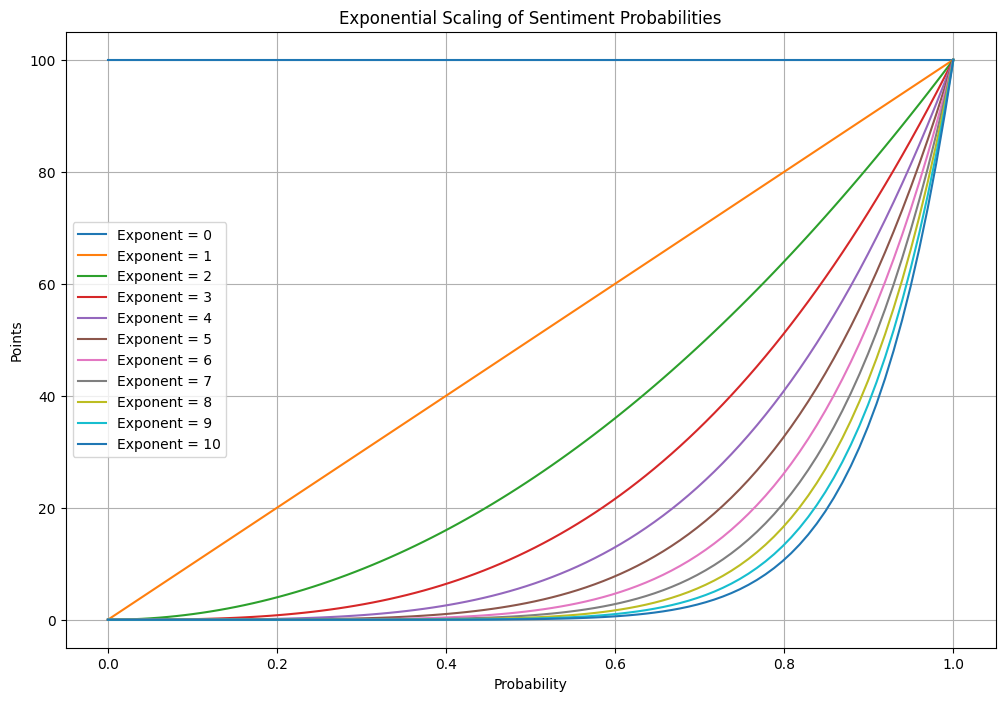

In [62]:
'''The purpose of this graph is to illustrate the impact of different 
exponents on the scaling of sentiment probabilities.'''


import matplotlib.pyplot as plt
import numpy as np

# Probabilities from 0 to 1
probabilities = np.linspace(0, 1, 100)

exponents = range(11)

# Create subplots for each exponent
plt.figure(figsize=(12, 8))

for exponent in exponents:
    points = (probabilities ** exponent) * 100
    plt.plot(probabilities, points, label=f'Exponent = {exponent}')

plt.xlabel('Probability')
plt.ylabel('Points')
plt.title('Exponential Scaling of Sentiment Probabilities')
plt.legend()
plt.grid(True)

plt.show()

In [63]:
def scaling_old(probabilities, k=3, linear=False):
    neutral_points = positive_points = negative_points = 0

    for prob_data in probabilities:
        class_prob = prob_data['class_prob']
        class_label = prob_data['class_label']
        
        if linear:
            points = class_prob * 100
        else:
            points = (class_prob ** k) * 100

        if class_label == 'neutral':
            neutral_points += points
        elif class_label == 'positive':
            positive_points += points
        elif class_label == 'negative':
            negative_points += points

    return [neutral_points, positive_points, negative_points]

In [64]:
def scaling(avg_array_list, k=3, linear=False):
    neutral_points = positive_points = negative_points = 0

    for avg_array in avg_array_list:
        for i, avg_value in enumerate(avg_array):
            
            if linear:
                points = avg_value * 100
            else:
                points = (avg_value ** k) * 100
    
            if i == 0:
                neutral_points += points
            elif i == 1:
                positive_points += points
            elif i == 2:
                negative_points += points

    return [neutral_points, positive_points, negative_points]

In [39]:
def average_array(probabilities):
    
    
    num_probabilities = len(probabilities)
    neutral_total = positive_total = negative_total = 0

    for prob_data in probabilities:
        class_prob = prob_data['class_prob']
        class_label = prob_data['class_label']

        if class_label == 'neutral':
            neutral_total += class_prob
        elif class_label == 'positive':
            positive_total += class_prob
        elif class_label == 'negative':
            negative_total += class_prob

    neutral_avg = neutral_total / num_probabilities if num_probabilities > 0 else 0
    positive_avg = positive_total / num_probabilities if num_probabilities > 0 else 0
    negative_avg = negative_total / num_probabilities if num_probabilities > 0 else 0

    return [neutral_avg, positive_avg, negative_avg]

In [66]:
from NewsSentiment import TargetSentimentClassifier
tsc = TargetSentimentClassifier()

sentiment = tsc.infer_from_text("Think twice before imposing Ulez tax on "
                                "hard-working Brits': Rishi Sunak blasts" , 
                                "Sadiq Khan" , "for his hated low emission "
                                               "zone expansion plan")
print(sentiment[0])

/Users/ameek/anaconda3/envs/Project/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9910047054290771}


In [33]:
from NewsSentiment import TargetSentimentClassifier
tsc = TargetSentimentClassifier()

def bounds_sentiment(mention_start, mention_end, sentence_start, sentence_end):
    try:
        left_segment = article_text[sentence_start:mention_start]
        mention_segment = article_text[mention_start:mention_end]
        right_segment = article_text[mention_end:sentence_end]

        sentiment = tsc.infer_from_text(left_segment, mention_segment, right_segment)
        print(sentiment[0])

        return sentiment[0]
    except Exception as e:
        print(f"Error during sentiment analysis: {e}")
        print(f"LEFT: {left_segment}")
        print(f"MENTION: {mention_segment}")
        print(f"RIGHT: {right_segment}")
        return None

In [68]:
# Code to identify sentence and highlight target - sending first instance of 
# entity in a sentence to NewsSentiment. 
# Misses some sentences that are un-punctuated in the ULEZ research article.
# Added ^ custom tokeization - will need to try a variety of articles to 
# improve.

from intervaltree import Interval, IntervalTree

print(clustered_entities[1]['Entity Name'])

START_HIGHLIGHT = '\033[0m'
END_HIGHLIGHT = '\033[94m'

GREEN = '\033[92m'
END_COLOR = '\033[0m'

cluster_positions = [(81, 91), (96, 99), (187, 199), (268, 280), (360, 366), 
                     (549, 579), (1006, 1013), (1230, 1255), (1360, 1367), 
                     (1479, 1503), (1735, 1745), (2099, 2108), (2503, 2510), 
                     (2669, 2670), (2688, 2689), (3393, 3400), (3741, 3746), 
                     (3771, 3773), (3796, 3798), (3866, 3869), (3936, 3938), 
                     (4136, 4146), (5326, 5342), (5352, 5355), (5915, 5924), 
                     (5999, 6010), (6154, 6157), (6342, 6349), (7103, 7110), 
                     (7216, 7225), (7468, 7479)]



bounds_tree = IntervalTree(Interval(start, end) for start, end in 
                           sentence_bounds)

processed_bounds = {}

for mention_start, mention_end in cluster_positions:
    overlap = bounds_tree.overlap(mention_start, mention_end)
    if overlap:
        first_unprocessed = None
        for interval in overlap:
            print(" ")
            sentence_start, sentence_end = interval.begin, interval.end
            bounds_key = (sentence_start, sentence_end)
            
            highlighted_text = (
                START_HIGHLIGHT + article_text[sentence_start:mention_start] 
                + END_HIGHLIGHT +article_text[mention_start:mention_end] +
                START_HIGHLIGHT + article_text[mention_end:sentence_end] + 
                END_HIGHLIGHT)
            print(START_HIGHLIGHT + f"Mention ({mention_start}, "
                                    f"{mention_end}) is within bounds "
                                    f"({sentence_start}, {sentence_end})")
            print(highlighted_text)
            
            # Paused idea of doing just the first mention for now.
            
            # if bounds_key not in processed_bounds:
            #     first_unprocessed = interval
            #     processed_bounds[bounds_key] = True
            #     bounds_sentiment(mention_start, mention_end, sentence_start, 
            #                      sentence_end)
            #     print(GREEN + "NewsSentiment Candidate as first bound "
            #                   "appearance" + END_COLOR)
            #     break

Khan
 
Mention (81, 91) is within bounds (0, 138)
'Think twice before imposing Ulez tax on hard-working Brits': Rishi Sunak blasts Sadiq Khan for his hated low emission zone expansion plan
 
Mention (96, 99) is within bounds (0, 138)
'Think twice before imposing Ulez tax on hard-working Brits': Rishi Sunak blasts Sadiq Khan for his hated low emission zone expansion plan
 
Mention (187, 199) is within bounds (139, 223)
- Keir Starmer told to 'get off the fence' over Sadiq Khan's Ulez by senior Tory MPs
 
Mention (268, 280) is within bounds (224, 301)
- Rishi Sunak led MPs asking Starmer to get London mayor to postpone the levy
 
Mention (360, 366) is within bounds (302, 489)
- READ MORE: Labour civil war over ULEZ intensifies after Khan's High Court win
Keir Starmer faced fresh calls last night for him to try to delay the expansion of London's clean air zone.
 
Mention (549, 579) is within bounds (490, 626)
Senior Tories said he should 'get off the fence' and force the capital's mayor S

In [69]:
START_HIGHLIGHT = '\033[0m'
END_HIGHLIGHT = '\033[94m'

GREEN = '\033[92m'
END_COLOR = '\033[0m'

bounds_data = {}

for entity in clustered_entities:
    entity_name = entity['Entity Name']
    entity_db_id = entity['entity_db_id']
    cluster_positions = entity['Cluster Info']['Cluster Positions']


    for mention_start, mention_end in cluster_positions:
        overlap = bounds_tree.overlap(mention_start, mention_end)
        if overlap:
            for interval in overlap:
                print(" ")
                sentence_start, sentence_end = interval.begin, interval.end
                bounds_key = (sentence_start, sentence_end)

                if bounds_key not in bounds_data:
                    bounds_data[bounds_key] = {}

                if entity_name not in bounds_data[bounds_key]:
                    bounds_data[bounds_key][entity_name] = {}
                    
                if entity_db_id not in bounds_data[bounds_key][entity_name]:
                    bounds_data[bounds_key][entity_name][entity_db_id] = []

                highlighted_text = (
                    START_HIGHLIGHT + 
                    article_text[sentence_start:mention_start] + END_HIGHLIGHT +
                    article_text[mention_start:mention_end] + START_HIGHLIGHT
                    + article_text[mention_end:sentence_end] + END_HIGHLIGHT)
                print(START_HIGHLIGHT + f"{entity_name} - Mention ({mention_start}, {mention_end}) is within bounds ({sentence_start}, {sentence_end})")
                print(highlighted_text)
                result = bounds_sentiment(mention_start, mention_end, 
                                          sentence_start, sentence_end)

                bounds_data[bounds_key][entity_name][entity_db_id].append(result)

                print(GREEN +f"NewsSentiment Candidateappearance{len(bounds_data[bounds_key][entity_name][entity_db_id])}" + END_COLOR)


 
Rishi Sunak - Mention (62, 73) is within bounds (0, 138)
'Think twice before imposing Ulez tax on hard-working Brits': Rishi Sunak blasts Sadiq Khan for his hated low emission zone expansion plan
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.8885825872421265}
NewsSentiment Candidateappearance1
 
Rishi Sunak - Mention (226, 237) is within bounds (224, 301)
- Rishi Sunak led MPs asking Starmer to get London mayor to postpone the levy
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.8556612730026245}
NewsSentiment Candidateappearance1
 
Rishi Sunak - Mention (926, 937) is within bounds (926, 1108)
Rishi Sunak last night led MPs and campaigners asking the Labour leader to make Mr Khan either postpone the £12.50 daily levy for older, more polluting vehicles or ditch it entirely.
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.7347527742385864}
NewsSentiment Candidateappearance1
 
Rishi Sunak - Mention (1269, 1291) is within bounds (1140, 1605)
Keir Starmer (

In [102]:
from decimal import Decimal, ROUND_HALF_UP

def round_array_to_1dp(arr):
    decimal_array = [Decimal(str(x)) for x in arr]
    original_sum = sum(decimal_array)
    rounded_array = [x.quantize(Decimal('0.0'), rounding=ROUND_HALF_UP) for x in decimal_array]
    rounded_sum = sum(rounded_array)
    adjustment = Decimal('100') - rounded_sum
    rounded_array[-1] += adjustment
    rounded_array = [float(x) for x in rounded_array]
    return rounded_array


In [103]:
def percentage_contribution(elements):
    total = sum(elements)
    percentage_contributions = [(element / total) * 100 for element in elements]
    return round_array_to_1dp(percentage_contributions)

In [105]:
entity_averages = {}

for bounds_key, entity_results in bounds_data.items():
    for entity_name, entity_db_ids in entity_results.items():
        for entity_db_id, results in entity_db_ids.items():
            # print(entity_name + " in:")
            # print(article_text[bounds_key[0]:bounds_key[1]])
            # print("Entity_db_id: " + str(entity_db_id))
            # print(results)
            # print(len(list(results)))
           
            avg = average_array(results)
            
            # Store entity - bound mention - bound text - average result in database
            
            
            if entity_name not in entity_averages:
                 entity_averages[entity_name] = {
                    "entity_db_ids": [entity_db_id],
                    "bounds_keys": [bounds_key],
                    "sentiment_scores": [avg],
                    "text": [article_text[bounds_key[0]:bounds_key[1]]],
                }
            else:
                entity_averages[entity_name]["entity_db_ids"].append(entity_db_id)
                entity_averages[entity_name]["bounds_keys"].append(bounds_key)
                entity_averages[entity_name]["sentiment_scores"].append(avg)
                entity_averages[entity_name]["text"].append(
                    article_text[bounds_key[0]:bounds_key[1]])
    
print('Sentiment Scores Format: [Neutral, Positive, Negative]')    
for entity_name, averages in entity_averages.items():
    entity_db_id = averages['entity_db_ids'][0]
    print(f"Averages for {entity_name} (Entity DB ID: {entity_db_id}):")
    sentiment_scores = averages['sentiment_scores']
    text = averages['text']
    bounds_keys = averages['bounds_keys']
    
    # for i, scores in enumerate(sentiment_scores):
    #     print("Sentiment Scores:", scores)
    #     print("Text:", text[i])
    #     print("Bounds Keys:", bounds_keys[i])
    #     print()
    #     db_manager.insert_bound_mention_data(entity_name, source_article_id,  entity_db_id, 
    #                                           scores, text[i], 
    #                                           bounds_keys[i])


    print('BOUND NUMBER')
    num_bound = len(averages['sentiment_scores'])
    print(num_bound)
    
    scaled_classification =scaling(averages['sentiment_scores'], k=3)
    exp_percent = percentage_contribution(scaled_classification)
    
    linear_scaled_classification =scaling(averages['sentiment_scores'], linear=True)
    linear_percent = percentage_contribution(
        linear_scaled_classification)
    
    print("Under exponential points system: ")
    print(round_array_to_1dp(scaled_classification))
    print(exp_percent)
    
    
    
    if (scaled_classification[0] > scaled_classification[1] and 
            scaled_classification[0] > scaled_classification[2]):
        print("Exponential Neutral Majority")
        
    elif (scaled_classification[1] > scaled_classification[0] and 
          scaled_classification[1] > scaled_classification[2]):
        print("Exponential Positive Majority")
        
    elif (scaled_classification[2] > scaled_classification[0] and 
          scaled_classification[2] > scaled_classification[1]):
        print("Exponential Negative Majority")
        
    print("\nUnder linear points system: ")
    print(round_array_to_1dp(linear_scaled_classification))
    print(linear_percent)
    
    if (linear_scaled_classification[0] > linear_scaled_classification[1] and 
            linear_scaled_classification[0] > linear_scaled_classification[2]):
        print("Linear Neutral Majority")
        
    elif (linear_scaled_classification[1] > linear_scaled_classification[0] 
          and linear_scaled_classification[1] > linear_scaled_classification[2]):
        print("Linear Positive Majority")
        
    elif (linear_scaled_classification[2] > linear_scaled_classification[0] 
          and linear_scaled_classification[2] > linear_scaled_classification[1]):
        print("Linear Negative Majority")

    print("------------------------------------------------")
    
    
    
    db_manager.insert_overall_sentiment(source_article_id, entity_db_id, num_bound, 
                             linear_percent[0], 
                             linear_percent[1], 
                             linear_percent[2], 
                             exp_percent[0], exp_percent[1], exp_percent[2])

    

Sentiment Scores Format: [Neutral, Positive, Negative]
Averages for Rishi Sunak (Entity DB ID: 1):
BOUND NUMBER
4
Under exponential points system: 
[204.8, 0.0, -104.8]
[100.0, 0.0, 0.0]
Exponential Neutral Majority

Under linear points system: 
[316.6, 0.0, -216.6]
[100.0, 0.0, 0.0]
Linear Neutral Majority
------------------------------------------------
Data inserted successfully into 'overall_sentiment' table.
Averages for Khan (Entity DB ID: 2):
BOUND NUMBER
22
Under exponential points system: 
[241.5, 352.1, -493.6]
[22.7, 33.1, 44.2]
Exponential Negative Majority

Under linear points system: 
[355.5, 674.9, -930.4]
[21.5, 40.9, 37.6]
Linear Positive Majority
------------------------------------------------
Data inserted successfully into 'overall_sentiment' table.
Averages for Keir Starmer (Entity DB ID: 3):
BOUND NUMBER
14
Under exponential points system: 
[375.3, 117.5, -392.8]
[55.3, 17.3, 27.4]
Exponential Neutral Majority

Under linear points system: 
[558.8, 218.0, -676.8]


In [106]:
db_manager.display_table('entity')
db_manager.display_table('article')
db_manager.display_table('bound_mention')
db_manager.display_table('overall_sentiment')

/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_51657/1178216027.py:229: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,source_article_id,name,type
0,1,1,Rishi Sunak,None
1,2,1,Khan,None
2,3,1,Keir Starmer,None
3,4,1,Ulez,None


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_51657/1178216027.py:229: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,headline,url,image_url,date_added
0,1,'Think twice before imposing Ulez tax on hard-...,https://www.dailymail.co.uk/news/article-12350...,https://i.dailymail.co.uk/1s/2023/07/28/21/737...,2023-11-08 17:59:09.772868


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_51657/1178216027.py:229: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,article_id,entity_id,bound_start,bound_end,avg_neutral,avg_positive,avg_negative,bound_text
0,1,1,1,0,138,0.888583,0.000000,0.000000,'Think twice before imposing Ulez tax on hard-...
1,2,1,1,224,301,0.855661,0.000000,0.000000,- Rishi Sunak led MPs asking Starmer to get Lo...
2,3,1,1,926,1108,0.734753,0.000000,0.000000,Rishi Sunak last night led MPs and campaigners...
3,4,1,1,1140,1605,0.686511,0.000000,0.000000,Keir Starmer (left) faced fresh calls last nig...
4,5,1,2,0,138,0.000000,0.000000,0.986028,'Think twice before imposing Ulez tax on hard-...
5,6,1,2,224,301,0.905671,0.000000,0.000000,- Rishi Sunak led MPs asking Starmer to get Lo...
6,7,1,2,926,1108,0.000000,0.000000,0.522323,Rishi Sunak last night led MPs and campaigners...
7,8,1,2,1140,1605,0.000000,0.000000,0.603612,Keir Starmer (left) faced fresh calls last nig...
8,9,1,2,139,223,0.000000,0.000000,0.915487,- Keir Starmer told to 'get off the fence' ove...
9,10,1,2,302,489,0.000000,0.399636,0.000000,- READ MORE: Labour civil war over ULEZ intens...


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_51657/1178216027.py:229: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,article_id,entity_id,num_bound,linear_neutral,linear_positive,linear_negative,exp_neutral,exp_positive,exp_negative
0,21,1,1,4,100.0,0.0,0.0,100.0,0.0,0.0
1,22,1,2,22,21.5,40.9,37.6,22.7,33.1,44.2
2,23,1,3,14,52.1,20.3,27.6,55.3,17.3,27.4
3,24,1,4,14,34.7,19.7,45.6,30.4,17.9,51.7


# ^ END SINGLE ARTICLE SECTION ^
 ----------------------------
# MULTI ARTICLE of above...

In [307]:
import psycopg2
import pandas as pd


class DatabaseManager:
    def __init__(self, host, database, user, password):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.conn = None
        self.close_on_error = False

    def connect(self):
        try:
            self.conn = psycopg2.connect(
                host=self.host,
                database=self.database,
                user=self.user,
                password=self.password
            )
        except psycopg2.Error as e:
            print("Error connecting to the database:", e)
            self.conn = None

    def create_entity_table(self):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        create_table_sql = """
            CREATE TABLE entity (
                id SERIAL PRIMARY KEY,
                source_article_id INT NOT NULL,
                name VARCHAR(50) NOT NULL,
                type VARCHAR(50)
            );
        """

        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'entity' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'entity' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()
                
    def create_bing_entity_table(self):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        create_table_sql = """
            CREATE TABLE bing_entity (
                id SERIAL PRIMARY KEY,
                entity_id INT REFERENCES entity(id) NOT NULL,
                name VARCHAR(255),
                description TEXT,
                image_url VARCHAR(255),
                web_search_url VARCHAR(255),
                bing_id VARCHAR(255),
                contractual_rules JSONB,
                entity_type_display_hint VARCHAR(255),
                entity_type_hints JSONB
            );
        """

        # Removed   CONSTRAINT unique_bing_id UNIQUE (bing_id)
        
        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'bing_entity' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'bing_entity' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()

    def create_article_table(self):
        if not self.conn:
            print("Database connection not established.")
            return
    
        cursor = self.conn.cursor()
    
        # Maybe I will consider adding sentences, word count, character to 
        # indicate relability, reading time etc to user.
        create_table_sql = """
            CREATE TABLE article (
                id SERIAL PRIMARY KEY,
                headline VARCHAR(511),
                url VARCHAR(511) NOT NULL,
                image_url VARCHAR(511),
                date_added TIMESTAMP NOT NULL
            );
        """
    
        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'article' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'article' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()
    
    def create_bound_mention_table(self):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        create_table_sql = """
            CREATE TABLE bound_mention (
                id SERIAL PRIMARY KEY,
                article_id INT NOT NULL,
                entity_id INT NOT NULL,
                bound_start INT NOT NULL,
                bound_end INT NOT NULL,
                avg_neutral NUMERIC,
                avg_positive NUMERIC,
                avg_negative NUMERIC,
                bound_text TEXT
            );
        """

        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'bound_mention' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'bound_mention' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()
                
                
    def create_overall_sentiment_table(self):
        if not self.conn:
            print("Database connection not established.")
            return
    
        cursor = self.conn.cursor()
    
        create_table_sql = """
            CREATE TABLE overall_sentiment (
                id SERIAL PRIMARY KEY,
                article_id INT NOT NULL,
                entity_id INT NOT NULL,
                num_bound INT NOT NULL,
                linear_neutral NUMERIC,
                linear_positive NUMERIC,
                linear_negative NUMERIC,
                exp_neutral NUMERIC,
                exp_positive NUMERIC,
                exp_negative NUMERIC
            );
        """
    
        try:
            cursor.execute(create_table_sql)
            self.conn.commit()
            print("Table 'overall_sentiment' created successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error creating the 'overall_sentiment' table:", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()            
    
    
    # TODO: Could add look up for entity being inserted but close match rather than exact - will 
    # TODO: make up for SOME cases where cluster resolution was not perfect.  
    
    def insert_entity(self, entity_name, source_article_id=None):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        try:
            # Does entity already exist?
            cursor.execute("SELECT id FROM entity WHERE name = %s", 
                           (entity_name,))
            existing_entity = cursor.fetchone()
            
            if existing_entity is not None:
                # Return to prevent duplicate entity creation later
                return existing_entity[0]
            else:
                # Insert if entity does not exist (name match)
                print('inserting')
                cursor.execute("INSERT INTO entity (name, type, "
                               "source_article_id) VALUES (%s, NULL, %s)",
                               (entity_name, source_article_id))
                self.conn.commit()
                 # Get ID from the entity insert row
                cursor.execute("SELECT id FROM entity WHERE name = %s", (entity_name,))
                new_entity = cursor.fetchone()
                return new_entity[0]
        except Exception as e:
            print("Error:", e)
        finally:
            cursor.close()
            
            
    def insert_into_bing_entity_table(self, entity_id, bing_entity_info):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        insert_sql = """
            INSERT INTO bing_entity (
                entity_id, name, description, image_url, web_search_url, bing_id, contractual_rules,
                entity_type_display_hint, entity_type_hints
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
        """


        try:
            cursor.execute(insert_sql, (
                entity_id,
                bing_entity_info.get('name', ''),
                bing_entity_info.get('description', ''),
                bing_entity_info.get('image_url', ''),
                bing_entity_info.get('web_search_url', ''),
                bing_entity_info.get('bing_id', ''),
                json.dumps(bing_entity_info.get('contractual_rules', [])),
                bing_entity_info.get('entity_type_display_hint', ''),
                json.dumps(bing_entity_info.get('entity_type_hints', []))
            ))

            self.conn.commit()
            print("Data inserted into 'bing_entity' successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error inserting data into 'bing_entity':", e)
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()
    
    def close(self):
        if self.conn:
            self.conn.close()
            
    def insert_article(self, url, headline=None, image_url=None):
        if not self.conn:
            print("Database connection not established.")
            return None

        cursor = self.conn.cursor()
        
        try:
            # Does entity already exist?
            cursor.execute("SELECT id FROM article WHERE url = %s", (url,))
            existing_article = cursor.fetchone()

            if existing_article is not None:
            # Article already exists, return its ID  return existing_article[0]
            # Or actually just return -1 we don't need to analyse this URL
            # again 
            # (unless article was edited but that's not a concern right now)
                print("existing_article contents:")
                print(existing_article)
                print(headline)
                print("Is already in the table rejecting and returning -1!")
                return -1
            else:
            # Insert the article if it doesn't exist
                cursor.execute("INSERT INTO article (headline, image_url, "
                               "url,  date_added) VALUES (%s, %s, %s, NOW()) "
                               " RETURNING id",
                           (headline, image_url, url))
                article_id = cursor.fetchone()[0]
                self.conn.commit()
                return article_id
        except Exception as e:
            print("Error:", e)
            return None
        finally:
            cursor.close()
            
    def display_table(self, table_name):
        if not self.conn:
            print("Database connection not established.")
            return
    
        try:
            query = f"SELECT * FROM {table_name};"
            df = pd.read_sql_query(query, self.conn)
            display(df)
        except Exception as e:
            print("Error:", e)
            
    def article_exists(self, url):
        if not self.conn:
            print("Database connection not established.")
            return False 

        cursor = self.conn.cursor()

        try:
            # Same URL already exists check
            cursor.execute("SELECT id FROM article WHERE url = %s", (url,))
            existing_article = cursor.fetchone()

            return existing_article is not None
        except Exception as e:
            print("Error:", e)
            return False
        finally:
            cursor.close()
            
    def entity_db_id_exists_in_bing(self, entity_db_id):
        if not self.conn:
            print("Database connection not established.")
            return False

        cursor = self.conn.cursor()

        check_query = """
            SELECT COUNT(*) FROM bing_entity
            WHERE entity_id = %s;
        """

        try:
            cursor.execute(check_query, (entity_db_id,))
            result = cursor.fetchone()[0]
            return result > 0
        except psycopg2.Error as e:
            print("Error checking if entity_db_id exists:", e)
            return False
        finally:
            if self.close_on_error:
                self.cursor.close()
                self.conn.close()


    def insert_bound_mention_data(self, entity_name, article_id, entity_db_id, 
                                   scores, text, bounds_keys):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        insert_data_sql = """
            INSERT INTO bound_mention (article_id, entity_id, bound_start, 
            bound_end, avg_neutral, avg_positive, avg_negative, bound_text)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
        """
        # print(len(sentiment_scores)) can't have here as not global cope as in single article case
        print(len(scores))
        print(len(bounds_keys))

        print(bounds_keys)
        article_id = article_id
        entity_id = entity_db_id
        bound_start = bounds_keys[0]
        bound_end = bounds_keys[1]
        avg_neutral = scores[0]
        avg_positive = scores[1]
        avg_negative = scores[2]
        bound_text = text

        data = (article_id, entity_id, bound_start, bound_end, avg_neutral, 
                avg_positive, avg_negative, bound_text)

        try:
            cursor.execute(insert_data_sql, data)
            self.conn.commit()
            print("Data inserted successfully for entity:", entity_name)
        except psycopg2.Error as e:
            self.conn.rollback()
            print(f"Error inserting data for entity {entity_name}:", e)

        cursor.close()
        
    def insert_overall_sentiment(self, article_id, entity_id, num_bound, linear_neutral, linear_positive, linear_negative, exp_neutral, exp_positive, exp_negative):
        if not self.conn:
            print("Database connection not established.")
            return
        
        cursor = self.conn.cursor()
        
        insert_data_sql = """
            INSERT INTO overall_sentiment (article_id, entity_id, num_bound, linear_neutral, linear_positive, linear_negative, exp_neutral, exp_positive, exp_negative)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
        """
        
        data = (article_id, entity_id, num_bound, linear_neutral, linear_positive, linear_negative, exp_neutral, exp_positive, exp_negative)
        
        try:
            cursor.execute(insert_data_sql, data)
            self.conn.commit()
            print("Data inserted successfully into 'overall_sentiment' table.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error inserting data into 'overall_sentiment' table:", e)
        finally:
            if self.close_on_error:
                cursor.close()
                self.conn.close()
                
                
    def drop_all_tables(self):
        if not self.conn:
            print("Database connection not established.")
            return

        cursor = self.conn.cursor()

        table_names = ['entity', 'article', 'bound_mention', 'overall_sentiment', 'bing_entity']

        try:
            for table_name in table_names:
                cursor.execute(f"DROP TABLE IF EXISTS {table_name} CASCADE;")

            self.conn.commit()
            print("All tables dropped successfully.")
        except psycopg2.Error as e:
            self.conn.rollback()
            print("Error dropping tables:", e)
        finally:
            if self.close_on_error:
                cursor.close()
                self.conn.close()

In [308]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import requests

class BeautifulRequests:
    
    @staticmethod
    def get_article_title(url):
        try:
            html_page = urlopen(url)
            soup = BeautifulSoup(html_page, 'html.parser')
            return soup.title.string
        except HTTPError as e:
            print(f"HTTP Error: {e}")
            return None
    
    
    @staticmethod
    def get_preview_image_url(url, timeout=1):
        try:
            response = requests.get(url, timeout=timeout)
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
    
                # Open Graph image tag attempt
                og_image = soup.find('meta', property='og:image')
                if og_image:
                    return og_image['content']
    
                # Otherwise, look for Twitter Card image tag
                twitter_image = soup.find('meta', name='twitter:image')
                if twitter_image:
                    return twitter_image['content']
    
            else:
                return None
    
        except (requests.exceptions.RequestException, TimeoutError) as e:
            print("Error:", e)
            return None


In [309]:
import spacy
import math
import re
from functools import reduce
from textblob import TextBlob
from collections import defaultdict


'''Determine if the URL can be fetched by all crawlers - adding politeness / adherence to robot policy.'''

from urllib.parse import urlparse
import urllib.robotparser

def can_fetch_url(url_to_check):
    parsed_url = urlparse(url_to_check)
    base_url = parsed_url.scheme + "://" + parsed_url.netloc
    # print(base_url)
    rules = urllib.robotparser.RobotFileParser()
    rules.set_url(base_url + "/robots.txt")
    rules.read()
    return rules.can_fetch("*", url_to_check)

'''Merge all instances of the same entity into a single entry with multiple 
positions. Where same means a lowercase word match. Place them into an
'entities' dictionary.'''

def merge_positions(entities, word):
        entity_key = (word.text + word.label_).lower()
        if entity_key in entities:
            entities[entity_key][1].append([word.start_char, word.end_char])
        else:
            entities[entity_key] = [word.text, [[word.start_char, word
            .end_char]], word.label_]
        return entities




def cleanse_cluster_text(cluster_text):
    return [word.strip() for word in cluster_text if word.lower().strip() not
            in undesired_words]

undesired_words = ["i", "he", "his", "she", "they", "it", "this", "that", 
                   "these", "those", "the", "a", "an", "of"]

'''10th November - ms caused match - though would have been knocked out due to low coreference 
 mentions count to sentences ratio anyway adding cover for this.

Entity Part: Ms
['SNP politician Kirsty Blackman', 'Ms Blackman', 'her', 'Ms Blackman']
0.5
------------------------------------------
Entity Name: Ms Baillee’s
['SNP politician Kirsty Blackman', 'Ms Blackman', 'her', 'Ms Blackman']
Max % Match: 0.5
PREDICTION:  MATCH

'''
def remove_titles(text):
    title_pattern = r"^(Mr|Mrs|Ms|Miss|Dr|Prof|Rev|Capt|Sir|Madam|Mx|Esq|Hon|Gen|Col|Sgt|Fr|Sr|Jr|Lord|Lady)\s"
    text = re.sub(title_pattern, "", text)    
    
    
    '''10th Nov adding as:
        {'Entity Name': 'Keith', 'Positions': [[11664, 11669], [12301, 12306], [14453, 14458], 
        [15005, 15010], [15286, 15291]], 'Label': 'PERSON', 'Num Positions': 5, 'Cluster Info': 
        {'Cluster ID': 12, 'Cluster Text': ['Keith', 'Keith', 'Keith', 'Keith', 'Hugo Keith KC',
        'Keith', 'Keith', 'Keith'], 'Cluster Positions': [(11664, 11669), (12301, 12306), 
        (12312, 12314), (13026, 13031), (13464, 13469), (14374, 14387), (14453, 14458),
        (15005, 15010), (15286, 15291)]}}
        would have been updated to Hugo Keith had it not been for KC which made it 3 words'''
    
    # Pattern for titles at the end
    title_pattern_end = r"\s*(KC|QC)\s*$"
    text = re.sub(title_pattern_end, "", text)
    return text


from constants import (ENTITY_THRESHOLD_PERCENT, 
                       MENTION_REQ_PER,
                       MERGE_REMOVAL_INDICATOR, 
                       COMBINED_REMOVAL_INDICATOR,
                       COMBINED_CLUSTER_ID_SEPARATOR)

class Article:
    # MENTION_REQ_PER = 0.20 - Moved to constants.py
    # ENTITY_THRESHOLD_PERCENT = 0.30 - Moved to constants.py
    
    def __init__(self, url, headline, text_body, NER):
        self.url = url
        self.NER = NER
        self.headline = headline
        self.image_url = None
        self.description = None
        self.text_body = text_body  # Added by trafilatura
        self.coref_clusters = None
        self.people_entities = None # NER results here.
        self.sentence_bounds = None
        self.num_sentences = None
        self.mention_threshold = None
        self.entity_to_cluster_mapping = []
        self.clustered_entities = None
        self.database_candidate = False
        self.database_id = None
        self.bounds_sentiment = None
        self.sentiment_analyser = None
        
    def set_sentiment_analyser(self, db_manager):
        self.sentiment_analyser = SentimentAnalyser(db_manager)
    
    def get_bounds_sentiment(self):
        try:
            self.bounds_sentiment = self.sentiment_analyser.process_clustered_entities(
                self.clustered_entities, self.sentence_bounds, self.text_body, debug=False
            )
        except Exception as e:
            print(f"Error processing bounds data for article {self.headline}. Error: {e}")
            self.bounds_sentiment = None

    
    @staticmethod
    def insert_intervals(initial_list, new_values):
        '''The insert_intervals function enables the segmentation of sentences provided by 
        TextBlob (as shown in the cell below) to be further divided into smaller boundaries. This
         division is based on the identification of specific points where it is deemed necessary 
         to split sentences, particularly within the context of news articles.'''
    
        def insert_recursive(intervals, values):
            if not values:
                return intervals # Base case: Return the intervals when there are no more values to insert.
    
            value = values[0]
            result = []
            for interval in intervals:
                if interval[0] <= value <= interval[1]:
                    # If the value falls within an existing interval, split the interval into two parts.
                    # The first part goes from the interval's start to the value (inclusive), and
                    # the second part goes from the value+1 to the interval's end.
                    if interval[0] < value:
                        # To mess around with intervals change value + - offset here.
                        result.append((interval[0], value))         
                    if value < interval[1]:
                        # To mess around with intervals change value + - offset here.
                        result.append((value+1, interval[1]))      
                else:
                    # If the value doesn't fall within the interval, keep the interval as is.
                    result.append(interval)
            # Recursively process other values.
            return insert_recursive(result, values[1:]) 
        
        # Recursive function call
        updated_list = insert_recursive(initial_list, new_values) 
        return updated_list
    

    @staticmethod
    def is_substring(entity1, entity2):
        return entity1.lower() in entity2.lower() or entity2.lower() in entity1.lower()
    
    @staticmethod
    def combine_entities(entities, cluster_text):
        combined_entity = None
    
        for entity1 in entities:
            for entity2 in entities:
                if entity1 != entity2:
                    combined1 = entity1 + ' ' + entity2
                    combined2 = entity2 + ' ' + entity1
    
                    if combined1 in cluster_text or combined2 in cluster_text:
                        combined_entity = combined1 if combined1 in cluster_text \
                            else combined2
                        break
    
        return combined_entity
    
    
    
    def print_clustered_entities(self):
        for entry in self.clustered_entities:
            print(entry)
            print()
    
    def print_entity_to_cluster_mapping(self):
        for entry in self.entity_to_cluster_mapping:
            print(entry)
            print()
    
    
    def create_entity_entry(self, entity_name, positions, label, num_positions):
        return {
            'Entity Name': entity_name,
            'Positions': positions,
            'Label': label,
            'Num Positions': num_positions,
            'Cluster Info': []
        }
    
    
    
    def determine_entity_to_cluster_mapping(self):
    
        '''
        Removing pronouns & other 'useless words' (his, her, he, I etc) then doing a % match rate on 
        entity text across cluster entries for each entity. If match rate % exceeds threshold 
        pair them.
        
        Improvement: Spliting the entity names into part words e.g. Sadiq Khan will be split into
        Sadiq and Khan for evaluation purposes. This way if they are mostly mentioned by first 
        or second name the match still has opportunity to take place.
        '''

        for entity_type, entities in self.people_entities.items():
            for entity in entities:
                entity_name, positions, label, num_positions = entity
                entity_entry = self.create_entity_entry(entity_name, positions, label, num_positions)
                self.process_clusters_for_entity(entity_entry, entity_name)
        
        
    def process_clusters_for_entity(self, entity_entry, entity_name):
        cluster_id = 0
        for index, (cluster_text, cluster_positions, _) in self.coref_clusters:
            cluster_id += 1
            
            cluster_text = cleanse_cluster_text(cluster_text)
            cleaned_cluster_text = [remove_titles(text) for text in cluster_text]
            
            
            # Check if the length of cleaned_cluster_text is less than 4 elements
            if len(cleaned_cluster_text) < 4:
                continue  # Skip this cluster and move to the next one
        
            total_coref_words = " ".join(cleaned_cluster_text)
            entity_parts = entity_name.split()
            max_percentage = 0.0
            
            winning_entity_part = None
            for entity_part in entity_parts:
                entity_count = total_coref_words.count(entity_part)
                 #  How well the entity name matches the cluster. 
                percentage = entity_count / len(cleaned_cluster_text)
                
                # Is this a better match than the previous best match? If so 
                # make this the new best match.
                if percentage > max_percentage: 
                    max_percentage = percentage
                    
                if percentage > 0.00:
                    print("Entity Part: " + entity_part)
                    print(cleaned_cluster_text)
                    print(percentage)
                    print('------------------------------------------')

            if max_percentage > 0.00:
                print("Entity Name: " + entity_name)
                print(cleaned_cluster_text)
                print("Max % Match: " + str(max_percentage))
                if max_percentage > ENTITY_THRESHOLD_PERCENT:
                    print("PREDICTION:  MATCH")
                    winning_entity_part = entity_part
                else:
                    print ("PREDICTION: INVALID")
                print('------------------------------------------')
                   
                    
            # cleaned_cluster_text = cleanse_cluster_text(cluster_text) believed redundant
            # total_coref_words = " ".join(cleaned_cluster_text)
            # entity_count = total_coref_words.count(entity_name)
            # percentage = entity_count / len(cleaned_cluster_text)
            
            if max_percentage > 0.00:
                print('Entity_name: ' + entity_name)
                if winning_entity_part:
                    print('Winning Entity Part: ' + winning_entity_part)
                print('Percentage: {:.2%}'.format(max_percentage))
            
            if max_percentage >= ENTITY_THRESHOLD_PERCENT:
                cluster_entry = {  
                'Cluster ID' : cluster_id,
                'Cluster Text': cluster_text,
                'Cluster Positions': cluster_positions
            }
                
                entity_entry['Cluster Info'] = cluster_entry
                self.entity_to_cluster_mapping.append(entity_entry)
                break
    # At this stage do we delete/empty some fields as they won't be used further?
        
    
    def set_coref_clusters(self, sorted_combined_clusters):
        # Add an ID to each cluster
        self.coref_clusters = list(enumerate(sorted_combined_clusters))
    
    
    
    def source_NER_people(self):
        
        '''SpaCy is a popular NLP library that offers pre-trained models for various languages, and 
            its NER component is capable of recognising and categorising named entities within text.
            It is utilised here to identify PERSON entities'''    
        
        NER = self.NER
        article_text = self.text_body
        article = NER(article_text)
        
        # Empty dictionary for 
        # people_entities
        people_entities = {}
            
        '''# Recommended mention - 'Discard a cluster c in a document d if |Mc| ≤ 0.2|Sd|,  
        where |...| is the number of mentions of a cluster (Mc) and sentences in a document (Sd)
        (NEWS-MTSC approach)'''
        
        entity_types = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW",
                        "LOC", "MONEY", "NORP", "ORDINAL", "ORG", "PERCENT", 
                        "PERSON", "PRODUCT", "QUANTITY", "TIME", "WORK_OF_ART"]
    
    
        entity_types = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW",
                "LOC", "MONEY", "NORP", "ORDINAL", "ORG", "PERCENT", 
                "PERSON", "PRODUCT", "QUANTITY", "TIME", "WORK_OF_ART"]

        entity_type_to_entities = {
        entity_type: [
            [
                entity_text,
                positions,
                label,
                len(positions)  # Count of positions
            ] for entity_text, positions, label in reduce(
                merge_positions,
                filter(lambda word: word.label_ == entity_type, article.ents),
                {}
            ).values()
        ] for entity_type in entity_types
        }
        
        for entity_type, entities in entity_type_to_entities.items():
            # print(f"Entity Type: {entity_type}")
            for entity in entities:
                entity_text, positions, label, num_positions = entity
                # print(f"Entity: {entity_text}")
                # print(f"Positions: {positions}")
                # print(f"Label: {label}")
                # print(f"Number of Positions: {num_positions}")
                # print()
            
        people_entities = {entity_type: entity_info for entity_type, entity_info in 
                       entity_type_to_entities.items() if entity_type == 'PERSON'}
        
        for entity in entity_type_to_entities[entity_type]:
            entity_text, positions, label, num_positions = entity
            if entity_type not in people_entities:
                people_entities[entity_type] = []
            people_entities[entity_type].append({
                'Entity': entity_text,
                'Positions': positions,
                'Label': label,
                'Number of Positions': num_positions
            })
        
        self.people_entities = people_entities
    

    
    
    def determine_sentences(self):
        
        '''
        Process the article text, tokenize by sentence and add custom adjustments to the 
        tokenization using insert intervals below.
        spaCy was not satisfactory for accurately tokenizing for sentence start / end
        characters. Trying textblob instead. TextBlob is a Python library for processing textual
        data that is bulit upon NLTK.
        
        TextBlob can provide me with the start and end of sentences by using the sentences 
        attribute of a TextBlob object. This attribute returns a list of Sentence objects, each 
        of which has a start and end property that indicate the index of the first and last 
        character of the sentence within the original text.'''

        
        # Process the article text and adjust tokenization
        article_text = self.text_body
        blob = TextBlob(article_text)
        sentences = blob.sentences
    
        # Determine custom tokenization:
        hyphen_sentences = re.split(r'\n-', article_text)
        # In testing article a new line and '-' hyphen use typically means consider 
        # a different sentence.
        hyphen_nl_pos = [pos for pos, char in enumerate(article_text) if 
                         article_text[pos:pos+2] == '\n-']  
        extra_split = hyphen_nl_pos
    
        sentence_bounds = [(int(sentence.start), int(sentence.end)) for sentence 
                           in sentences]
    
        # Insert custom intervals
        updated_list = Article.insert_intervals(sentence_bounds, extra_split)
        
        self.sentence_bounds = updated_list
        self.num_sentences = len(list(sentence_bounds))
        self.mention_threshold = math.floor(self.num_sentences * MENTION_REQ_PER)
    
    
    def entity_cluster_map_consolidation(self):
        '''
        Purposes of below code:

        1. Substring Matching: If one entity is a substring of another entity, they 
        are considered as candidates for consolidation. For example, if "Rishi" is a 
        substring of "Rishi Sunak," the code merges them into the longer version, "Rishi Sunak."

        2. First and Second Name Combination: If there are two entities, one 
        representing the first name and the other representing the last name, and 
        they share the same coreference cluster, the code attempts to combine them 
        into a single entity.
        
        3. 9th November - add while loop to see if continuing consolidation until no more 
        consolidation takes place results in a better consolidation as theorised.
        
        4. 16th November - resolve instances of 'King\n11:43' which should be King.
        
        '''
        
        
        
        cluster_dict = defaultdict(list)
        debug = False
        for entry in self.entity_to_cluster_mapping:
            entity_name = entry['Entity Name']
            cluster_id = entry['Cluster Info']['Cluster ID']
            cluster_dict[cluster_id].append(entry)
    

        # While loop to continue consolidation until no more consolidation can be done
        consolidation_done = True
        while consolidation_done:
            consolidation_done = False
            for cluster_id, entries in cluster_dict.items():
                if len(entries) > 1:
                    combined_entry = None
                    for i, entry1 in enumerate(entries):
                        for j, entry2 in enumerate(entries):
                            entry1 = Article.update_entity_name(entry1)
                            entry2 = Article.update_entity_name(entry2)
                            
                            if i < j:
                                entity_1_name = entry1['Entity Name']
                                entity_2_name = entry2['Entity Name']
                                
                                cluster_text = entries[0]['Cluster Info']['Cluster Text']
                                combined_entity = Article.combine_entities([entity_1_name, 
                                                                    entity_2_name], 
                                                                   cluster_text)
                                
                                if Article.is_substring(entity_1_name, entity_2_name):
                                    if len(entity_1_name) > len(entity_2_name):
                                        if entry2 in entries:
                                            entries.remove(entry2)
                                        # Coreference cluster will be used anyway -200 to
                                        # indicate merge via removal.
                                        entry1['Num Positions'] = int(MERGE_REMOVAL_INDICATOR) 
                                        entry1['Positions'] = int(MERGE_REMOVAL_INDICATOR) 
                                    
                                    else:
                                        if entry1 in entries:
                                            entries.remove(entry1)
                                        # Coreference cluster will be used anyway -200 to
                                        # indicate merge via removal.
                                        entry2['Num Positions'] = int(MERGE_REMOVAL_INDICATOR) 
                                        entry2['Positions'] = int(MERGE_REMOVAL_INDICATOR) 
                                    
                                    consolidation_done = True
                                elif combined_entity in cluster_text:
                                    combined_entry = {
                                        'Entity Name': combined_entity,
                                        # Coreference cluster will be used anyway -100 to
                                        # indicate merge via combined entity.
                                        'Positions': int(COMBINED_REMOVAL_INDICATOR), 
                                        'Label': entry1['Label'], 
                                        # Coreference cluster will be used anyway -100 to
                                        # indicate merge via combined entity.
                                        'Num Positions': int(COMBINED_REMOVAL_INDICATOR),  
                                        'Cluster Info': entry1['Cluster Info'] 
                                    }
                                    entries.remove(entry1)
                                    entries.remove(entry2)
                                    consolidation_done = True
                        if combined_entry:
                            entries.append(combined_entry)  
                       
            '''
            Now look across cluster ids (above we stayed within a cluster id) for substrings of
            entity names and merge together cluster ids, positions and text.
            '''             
            for cluster_id1, entries1 in cluster_dict.items():
                for cluster_id2, entries2 in cluster_dict.items():
                    if cluster_id1 != cluster_id2:  # Prevents comparing entries within the same cluster
                        for entry1 in entries1:
                            for entry2 in entries2:
                                entry1 = Article.update_entity_name(entry1)
                                entry2 = Article.update_entity_name(entry2)
                                
                                entity_1_name = entry1['Entity Name']
                                entity_2_name = entry2['Entity Name']
                                # Check if an entity name is a substring of another.
                                if entity_1_name in entity_2_name or entity_2_name in entity_1_name:
                                    print('cross cluster merge triggered!')
                                    print(entity_1_name)
                                    print(entity_2_name)
                                    # Combine cluster IDs with '0000' in between as a strong indicator.
                                    combined_cluster_id = f"{entry1['Cluster Info']['Cluster ID']}{COMBINED_CLUSTER_ID_SEPARATOR}{entry2['Cluster Info']['Cluster ID']}"
    
                                    # Set the new cluster ID
                                    entry1['Cluster Info']['Cluster ID'] = combined_cluster_id
                                    entry2['Cluster Info']['Cluster ID'] = combined_cluster_id
        
                                    # Append cluster texts and positions to entry 1.
                                    entry1['Cluster Info']['Cluster Text'].extend(entry2['Cluster Info']['Cluster Text'])
                                    entry1['Cluster Info']['Cluster Positions'].extend(entry2['Cluster Info']['Cluster Positions'])
                                    
                                    if len(entity_2_name) > len(entity_1_name):
                                        entry1['Entity Name'] = entity_2_name
                                    entries2.remove(entry2)
                                    consolidation_done = True
                        
        
    
        clustered_entities = [entry for entries in cluster_dict.values() for entry in entries]
        
        before_len = len(clustered_entities)
        
        cleaned_entities = []
        
        # Resolve \n in entity name instances and any below mention threshold.
        for entity in clustered_entities:
            entity_name = entity['Entity Name']
            cleaned_name = re.split(r'\n\d*:', entity_name)[0].strip()
        

            entity_name = remove_titles(cleaned_name)

            
            '''Found 'Entity Name': 'Reginald D. Hunter’s' - handle removing 's from last word'''
            
            
            entity_name = entity_name.replace('’', "'").replace('‘', "'")

            
            # Split the entity name into words
            words = entity_name.split()
            
            # Check if the last word ends with 's, and if so, remove it
            if words and words[-1].endswith("'s"):
                words[-1] = words[-1][:-2]  # Remove 's from the last word
        
            # Join the words back into the entity name
            cleaned_name = ' '.join(words)
        
            # Capitalise the first letter of each word and make the rest lowercase
            cleaned_name = ' '.join(word.capitalize() for word in words)
        
            # Replace the original entity name with the cleaned name
            entity['Entity Name'] = cleaned_name

            
            cluster_positions = entity['Cluster Info']['Cluster Positions']
            cluster_id = entity['Cluster Info']['Cluster ID']
        
            # Count the number of entries in cluster_positions
            num_entries = len(cluster_positions)
            
            # Check if the number of entries is below the threshold
            if num_entries < self.mention_threshold:
                print(f"Cluster ID {cluster_id} has {num_entries} entries, which is below the "
                      f"threshold of {self.mention_threshold}.")
                print(f"Removing entity {entity['Entity Name']} with Cluster ID {cluster_id} due "
                      f"to low mention count:")
                print(entity['Cluster Info'])
                clustered_entities.remove(entity)
                continue 
            
            # If the entity is not removed, add it to the cleaned list
            cleaned_entities.append(entity)
        
        clustered_entities = cleaned_entities    
        new_length = len(clustered_entities)
        
        print(f"number of entities before mention threshold: {before_len}")
        print(f"number of entities after mention thresold: {new_length}")
        
        
        clustered_entities = self.clean_up_substrings(clustered_entities)
        
        
        self.clustered_entities = clustered_entities
        
        
  
        
        # Is this article going to go on the web app? If clustered_entities > 0 then yes so get 
        # article parts and insert into database.
        if new_length > 0:
            self.set_database_candidate_true()
    
    
    def set_database_candidate_true(self):
        self.database_candidate = True
        # headline_request = BeautifulRequests.get_article_title(self.url)
        # if headline_request is not None:
        #     print("Headline Found: " + headline_request)
        #     print("Original Headline: " + self.headline)
        #     self.headline = headline_request 
        self.image_url = BeautifulRequests.get_preview_image_url(self.url)
    
     
    def clean_up_substrings(self, clustered_entities):

        longest_names = {}
        entities_to_keep = []
        
        # Identify longest names in cluster ID and remove shorter ones
        for entity in clustered_entities:
            cluster_id = entity['Cluster Info']['Cluster ID']
            entity_name = entity['Entity Name']
            current_longest = longest_names.get(cluster_id, "")
        
            if len(entity_name) > len(current_longest):
                # Remove the shorter entity without adding it to the list of entities to keep
                if current_longest:
                    entities_to_keep = [e for e in clustered_entities if e['Cluster Info']['Cluster ID'] != cluster_id]
                longest_names[cluster_id] = entity_name
        
                # Add the entity to the list of entities to keep
                entities_to_keep.append(entity)
        
        # Set merge indicator for entities with more than one associated name in the original list
        for entity in clustered_entities:
            cluster_id = entity['Cluster Info']['Cluster ID']
            if len([e for e in entities_to_keep if e['Cluster Info']['Cluster ID'] == cluster_id]) > 1:
                entity['Num Positions'] = int(MERGE_REMOVAL_INDICATOR)
                entity['Positions'] = int(MERGE_REMOVAL_INDICATOR)
        return entities_to_keep
     
     
            
    @staticmethod
    def update_entity_name(entry):
        '''Calls remove titles and removes possessives before checking if an entity name is a
         substring of a 2 word entry in the coref cluster e.g. Johnson should become Boris Johnson'''
        
        entity_name = entry['Entity Name']
        cluster_text = entry['Cluster Info']['Cluster Text']

        for text in cluster_text:
            # Remove titles as not relevant
            text = remove_titles(text)
            # Remove possessive markers for comparison
            text = text.replace("’s", "")
            # Check if the current entity name is a substring of a 2-word cluster text entry
            if len(text.split()) == 2 and entity_name in text:
                entry['Entity Name'] = text
                break
        return entry


In [310]:
from decimal import Decimal, ROUND_HALF_UP
class ArrayUtility:
    @staticmethod
    def scaling(avg_array_list, k=3, linear=False):
        neutral_points = positive_points = negative_points = 0

        for avg_array in avg_array_list:
            for i, avg_value in enumerate(avg_array):
    
                if linear:
                    points = avg_value * 100
                else:
                    points = (avg_value ** k) * 100
    
                if i == 0:
                    neutral_points += points
                elif i == 1:
                    positive_points += points
                elif i == 2:
                    negative_points += points
        return [neutral_points, positive_points, negative_points]

    @staticmethod
    def average_array(probabilities):
        
        num_probabilities = len(probabilities)
        neutral_total = positive_total = negative_total = 0
        
        for prob_data in probabilities:
            if not prob_data:
                continue
            print("prob_data:", prob_data)
            class_prob = prob_data['class_prob']
            class_label = prob_data['class_label']
    
            if class_label == 'neutral':
                neutral_total += class_prob
            elif class_label == 'positive':
                positive_total += class_prob
            elif class_label == 'negative':
                negative_total += class_prob
    
        neutral_avg = neutral_total / num_probabilities if num_probabilities > 0 else 0
        positive_avg = positive_total / num_probabilities if num_probabilities > 0 else 0
        negative_avg = negative_total / num_probabilities if num_probabilities > 0 else 0
    
        return [neutral_avg, positive_avg, negative_avg]

    from decimal import Decimal, ROUND_HALF_UP

    @staticmethod
    def round_array_to_1dp(arr):
        decimal_array = [Decimal(str(x)) for x in arr]
        original_sum = sum(decimal_array)
        rounded_array = [x.quantize(Decimal('0.0'), rounding=ROUND_HALF_UP) for x in decimal_array]
        rounded_sum = sum(rounded_array)
        adjustment = Decimal('100') - rounded_sum
        rounded_array[-1] += adjustment
        rounded_array = [float(x) for x in rounded_array]
        return rounded_array
    
    @staticmethod
    def percentage_contribution(elements):
        total = sum(elements)
        percentage_contributions = [(element / total) * 100 for element in elements]
        return ArrayUtility.round_array_to_1dp(percentage_contributions)

In [311]:
from constants import EXPONENTIAL_K_VALUE
from intervaltree import Interval, IntervalTree
from NewsSentiment import TargetSentimentClassifier

class SentimentAnalyser:
    
    def __init__(self, db_manager):
        self.tsc = TargetSentimentClassifier()
        self.db_manager = db_manager
        
    def bounds_sentiment(self, mention_start, mention_end, sentence_start, sentence_end, 
                         article_text):
        try:
            left_segment = article_text[sentence_start:mention_start]
            mention_segment = article_text[mention_start:mention_end]
            right_segment = article_text[mention_end:sentence_end]
        
            sentiment = self.tsc.infer_from_text(left_segment, mention_segment, right_segment)
            print(sentiment[0])
        
            return sentiment[0]
        
        except Exception as e:
            print(f"Error during sentiment analysis: {e}")
            print(f"LEFT: {left_segment}")
            print(f"MENTION: {mention_segment}")
            print(f"RIGHT: {right_segment}")
            return None

    def process_clustered_entities(self, clustered_entities, sentence_bounds, article_text, 
                                   debug):
        START_HIGHLIGHT = '\033[0m'
        END_HIGHLIGHT = '\033[94m'
        GREEN = '\033[92m'
        END_COLOR = '\033[0m'
        
        bounds_tree = IntervalTree(Interval(start, end) for start, end in 
                           sentence_bounds)
        
        bounds_sentiment = {}
    
        ''' Some entities at this point may not have been fully consolidated.
            Running the model is the most intensive part of this process.
            Since non consolidated entities likely have the same coref cluster.
            Running model over save cluster more than once is wasteful.''' 
            
        cluster_id_mapping = {}  # Map cluster_id to bounds_sentiment

        for entity in clustered_entities:
            entity_name = entity['Entity Name']
            entity_db_id = entity['entity_db_id']
            cluster_positions = entity['Cluster Info']['Cluster Positions']
            cluster_id = entity['Cluster Info']['Cluster ID']
            
            # Check if the cluster_id has been seen before
            if cluster_id in cluster_id_mapping:
                print('Using cached bounds sentiment')
            # If so use the cached bounds_sentiment
                bounds_sentiment = cluster_id_mapping[cluster_id]
            else:
                bounds_sentiment = {}
                results_cache = {}  # Cache results for each cluster ID
            
                for mention_start, mention_end in cluster_positions:
                    overlap = bounds_tree.overlap(mention_start, mention_end)
                    if overlap:
                        for interval in overlap:
                            print(" ")
                            sentence_start, sentence_end = interval.begin, interval.end
                            bounds_key = (sentence_start, sentence_end)
    
                            if bounds_key not in bounds_sentiment:
                                bounds_sentiment[bounds_key] = {}
    
                            if entity_name not in bounds_sentiment[bounds_key]:
                                bounds_sentiment[bounds_key][entity_name] = {}
    
                            if entity_db_id not in bounds_sentiment[bounds_key][entity_name]:
                                bounds_sentiment[bounds_key][entity_name][entity_db_id] = []
    
                            highlighted_text = (
                                START_HIGHLIGHT +
                                article_text[sentence_start:mention_start] + END_HIGHLIGHT +
                                article_text[mention_start:mention_end] + START_HIGHLIGHT +
                                article_text[mention_end:sentence_end] + END_HIGHLIGHT)
                            
                            
                            result = self.bounds_sentiment(mention_start, mention_end,
                                                           sentence_start, sentence_end, article_text)
    
                            if cluster_id not in results_cache:
                                result = self.bounds_sentiment(
                                    mention_start, mention_end, sentence_start, sentence_end, article_text
                                )
                                results_cache.setdefault(cluster_id, []).append(result)
                            else:
                               # print("Results Cache")
                               # print(results_cache)
                                results_cache[cluster_id].append(result)
                            
                            
                            bounds_sentiment[bounds_key][entity_name][entity_db_id].append(result)
                                
                            if debug:
                                print(START_HIGHLIGHT + f"{entity_name} - Mention ({mention_start}, {mention_end}) is within bounds ({sentence_start}, {sentence_end})")
                                print(highlighted_text)
                                print(GREEN + f"NewsSentiment Candidateappearance{len(bounds_sentiment[bounds_key][entity_name][entity_db_id])}" + END_COLOR)
                    
                cluster_id_mapping[cluster_id] = bounds_sentiment
                        
        return bounds_sentiment



    def average_sentiment_results(self, source_article_id, bounds_sentiment, article_text):       
        entity_averages = {}

        
        for bounds_key, entity_results in bounds_sentiment.items():
            for entity_name, entity_db_ids in entity_results.items():
                for entity_db_id, results in entity_db_ids.items():
                    if not results: # Empty results for an entity? Skip...
                        continue
                    print(results)
                    avg = ArrayUtility.average_array(results)
                    
                    # Store entity - bound mention - bound text - average result in database

                    if entity_name not in entity_averages:
                         entity_averages[entity_name] = {
                            "entity_db_ids": [entity_db_id],
                            "bounds_keys": [bounds_key],
                            "sentiment_scores": [avg],
                            "text": [article_text[bounds_key[0]:bounds_key[1]]],
                        }
                    else:
                        entity_averages[entity_name]["entity_db_ids"].append(entity_db_id)
                        entity_averages[entity_name]["bounds_keys"].append(bounds_key)
                        entity_averages[entity_name]["sentiment_scores"].append(avg)
                        entity_averages[entity_name]["text"].append(
                            article_text[bounds_key[0]:bounds_key[1]])
            
        print('Sentiment Scores Format: [Neutral, Positive, Negative]')    
        for entity_name, averages in entity_averages.items():
            entity_db_id = averages['entity_db_ids'][0]
            print(f"Averages for {entity_name} (Entity DB ID: {entity_db_id}):")
            sentiment_scores = averages['sentiment_scores']
            text = averages['text']
            bounds_keys = averages['bounds_keys']
            
            for i, scores in enumerate(sentiment_scores):
                # print("Sentiment Scores:", scores)
                # print("Text:", text[i])
                # print("Bounds Keys:", bounds_keys[i])
                # print()
                db_manager.insert_bound_mention_data(entity_name, source_article_id, entity_db_id, 
                                                      scores, text[i], 
                                                      bounds_keys[i])
                
        
            print('BOUND NUMBER')
            num_bound = len(averages['sentiment_scores'])
            print(num_bound)
            
            scaled_classification = ArrayUtility.scaling(averages['sentiment_scores'], 
                                                         k=EXPONENTIAL_K_VALUE)
            exp_percent = ArrayUtility.percentage_contribution(scaled_classification)
            
            linear_scaled_classification =ArrayUtility.scaling(averages['sentiment_scores'], 
                                                           linear=True)
            linear_percent = ArrayUtility.percentage_contribution(
                linear_scaled_classification)
            
            
            '''Creating a list of tuples, 'systems,' containing names and classifications of two 
            points allocation approaches. Iterating over the list to print array values rounded 
            to 1 decimal place, percentage contributions, and the majority class for each system.'''
            
            systems = [("Exponential", scaled_classification), ("Linear", linear_scaled_classification)]

            for system_name, system_classification in systems:
                print(f"Under {system_name} points system:")
                print(ArrayUtility.round_array_to_1dp(system_classification))
                print(ArrayUtility.percentage_contribution(system_classification))
            
                majority_class = max(zip(["Neutral", "Positive", "Negative"], system_classification), key=lambda x: x[1])
                print(f"{system_name} {majority_class[0]} Majority")
            
            print("------------------------------------------------")
            
            
            
            db_manager.insert_overall_sentiment(source_article_id, entity_db_id, num_bound, 
                                     linear_percent[0], 
                                     linear_percent[1], 
                                     linear_percent[2], 
                                     exp_percent[0], exp_percent[1], exp_percent[2])

    

In [312]:
entry = {'Entity Name': 'Johnson', 'Positions': [[9323, 9330], [11643, 11650], [11818, 11825], 
                                               [12388, 12395], [12776, 12783]], 'Label': 'PERSON', 'Num Positions': 5, 'Cluster Info': {'Cluster ID': 6, 'Cluster Text': ['Boris Johnson', 'Johnson', 'Johnson', 'Boris Johnson', 'Johnson’s', 'the PM', 'Johnson', 'Johnson'], 'Cluster Positions': [(9068, 9081), (9323, 9330), (11643, 11650), (11655, 11658), (11681, 11694), (11706, 11709), (11770, 11773), (11818, 11827), (12284, 12290), (12388, 12395), (12434, 12436), (12776, 12783)]}}

entity_name = entry['Entity Name']
cluster_text = entry['Cluster Info']['Cluster Text']

for text in cluster_text:
    # Remove titles as not relevant
    text = remove_titles(text)
    # Remove possessive markers for comparison
    text = text.replace("’s", "")
    # Check if the current entity name is a substring of a 2-word cluster text entry
    if len(text.split()) == 2 and entity_name in text:
        entry['Entity Name'] = text
        break
                
print(entry)

{'Entity Name': 'Boris Johnson', 'Positions': [[9323, 9330], [11643, 11650], [11818, 11825], [12388, 12395], [12776, 12783]], 'Label': 'PERSON', 'Num Positions': 5, 'Cluster Info': {'Cluster ID': 6, 'Cluster Text': ['Boris Johnson', 'Johnson', 'Johnson', 'Boris Johnson', 'Johnson’s', 'the PM', 'Johnson', 'Johnson'], 'Cluster Positions': [(9068, 9081), (9323, 9330), (11643, 11650), (11655, 11658), (11681, 11694), (11706, 11709), (11770, 11773), (11818, 11827), (12284, 12290), (12388, 12395), (12434, 12436), (12776, 12783)]}}


In [313]:
from fastcoref import FCoref

def perform_coreference_resolution(article_texts, batch_size=100):
    model = FCoref(device='mps')
    
    preds = model.predict(texts=article_texts, max_tokens_in_batch=batch_size)
    
    # Empty list to store clusters for each article
    article_text_clusters = []  
    
    for pred in preds:
        clustersText = pred.get_clusters()
        clustersPositions = pred.get_clusters(as_strings=False)
        clustersPositions = pred.get_clusters(as_strings=False)
        
        combined_clusters = [(text, positions, len(text)) for text, positions in zip
        (clustersText, clustersPositions)]
        sorted_combined_clusters = sorted(combined_clusters, key=lambda x: x[2], reverse=True)
        
        article_text_clusters.append(sorted_combined_clusters)
    
    return article_text_clusters

In [314]:
db_manager.close()

In [315]:
db_manager = DatabaseManager(
    host="localhost",
    database="prominent_profiles",
    user="python_access",
    password="LOCAL_USE_ONLY"
)

db_manager.connect()
db_manager.drop_all_tables()
db_manager.create_entity_table()
db_manager.create_bing_entity_table()
db_manager.create_article_table()
db_manager.create_bound_mention_table()
db_manager.create_overall_sentiment_table()    

All tables dropped successfully.
Table 'entity' created successfully.
Table 'bing_entity' created successfully.
Table 'article' created successfully.
Table 'bound_mention' created successfully.
Table 'overall_sentiment' created successfully.


In [257]:
import trafilatura
import json
# Read articles from a JSON file
with open("articles_loop_results.json", "r") as articles_file:
    articles = json.load(articles_file)

# Read search results from a JSON file
with open("search_results_loop_results.json", "r") as results_file:
    search_results_list = json.load(results_file)
    
processed_urls = set()
article_objects = []
NER = spacy.load("en_core_web_sm")


for article in articles[1:50]:
    url = article["url"]

    # Check if the URL has been seen before
    if url in processed_urls:
        continue  # Skip this article

    try:
        if can_fetch_url(url):
            downloaded = trafilatura.fetch_url(url)
            article_text = trafilatura.extract(downloaded, favour_precision=True,  
                                                include_comments=False,  include_images=False,   
                                                include_tables=False)
            if article_text and len(article_text) > 250:
                article = Article(url, article["title"], article_text, NER)
                article_objects.append(article)

                # Mark the URL as processed
                processed_urls.add(url)
    except Exception as e:
        print(f"Error processing article: {url}")
        print(f"Error message: {str(e)}")
        
print(len(article_objects))


# Buggy - not recommended approach.
# # Don't process articles already in the database
# for article in article_objects:
#     if db_manager.article_exists(article.url):
#         article_objects.remove(article)
        
# 
# new_article_objects = []
# for article in article_objects:
#     if not db_manager.article_exists(article.url):
#         new_article_objects.append(article)
# article_objects = new_article_objects
# print(len(article_objects))


11/19/2023 19:00:05 - ERROR - 	 lxml parsing failed: Document is empty


KeyboardInterrupt: 

In [48]:
article_texts = [article.text_body for article in article_objects]
article_text_clusters = perform_coreference_resolution(article_texts)

In [50]:
for article, clusters in zip(article_objects, article_text_clusters):
    article.set_coref_clusters(clusters)

In [51]:
for article in article_objects:
    article.source_NER_people()
    article.determine_sentences()


In [52]:
for article in article_objects:
    print(article.headline)
    print(article.people_entities)
    print('---------------------')

Ex-civil service head joked about need to sack Hancock ‘to protect NHS’, inquiry hears – <b>UK politics</b> live
{'PERSON': [['Rishi Sunak', [[117, 128], [5384, 5395]], 'PERSON', 2], ['Mark Rowley', [[189, 200], [2473, 2484], [5456, 5467], [7740, 7751]], 'PERSON', 4], ['Suella Braverman', [[638, 654], [5905, 5921], [9872, 9888], [11177, 11193], [14810, 14826]], 'PERSON', 5], ['Sunak', [[1182, 1187], [1521, 1526], [6449, 6454], [6788, 6793]], 'PERSON', 4], ['Braverman', [[1431, 1440], [6698, 6707], [10869, 10878], [14863, 14872]], 'PERSON', 4], ['Remembrance', [[2905, 2916], [8172, 8183]], 'PERSON', 2], ['Akshata Murty', [[3739, 3752]], 'PERSON', 1], ['Johnny Mercer', [[3950, 3963]], 'PERSON', 1], ['James Sunderland', [[4337, 4353]], 'PERSON', 1], ['Bracknell', [[4366, 4375]], 'PERSON', 1], ['John Crace', [[8993, 9003]], 'PERSON', 1], ['Boris Johnson', [[9068, 9081], [11681, 11694]], 'PERSON', 2], ['Covid', [[9222, 9227], [9342, 9347], [14259, 14264], [14337, 14342]], 'PERSON', 4], ['Se

In [53]:
for article in article_objects:
    article.determine_entity_to_cluster_mapping()
    article.print_entity_to_cluster_mapping()

Entity Part: Rishi
['Sunak', 'Rishi Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Rishi Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak']
0.125
------------------------------------------
Entity Part: Sunak
['Sunak', 'Rishi Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Rishi Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak']
1.0
------------------------------------------
Entity Name: Rishi Sunak
['Sunak', 'Rishi Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Rishi Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak']
Max % Match: 1.0
PREDICTION:  MATCH
------------------------------------------
Entity_name: Rishi Sunak
Winning Entity Part: Sunak
Percentage: 100.00%
Entity Part: Mark
['Sedwill', 'Mark Sedwill', 'Sedwill', 'Sedwill', 'Sedwill', 'my', 'Sedwill', 'Sedwill', 'Sedwill', 'your', 'Sedwill', 'Sedwill', 'Sedwill', 'Sedwill’s', 'Sedwill', 'you', 'Sedwill', 'Sedwill', 'Sedwil

In [54]:
for article in article_objects:
    article.entity_cluster_map_consolidation()

Rishi Sunak
Rishi Sunak
Suella Braverman
Suella Braverman
Cluster ID 7 has 11 entries, which is below the threshold of 24.
Removing entity Suella Braverman with Cluster ID 7 due to low mention count:
{'Cluster ID': 7, 'Cluster Text': ['Suella Braverman, the home secretary', 'Braverman', 'Suella Braverman, the home secretary', 'Braverman', 'Suella Braverman, the home secretary', 'her', 'Braverman', 'Suella Braverman, the home secretary', 'Suella Braverman, the home secretary,'], 'Cluster Positions': [(638, 674), (716, 719), (1431, 1440), (5905, 5941), (5983, 5986), (6698, 6707), (9872, 9908), (10299, 10302), (10869, 10878), (11177, 11213), (11177, 11214)]}
Boris Johnson
Boris Johnson
Cluster ID 6 has 12 entries, which is below the threshold of 24.
Removing entity Boris Johnson with Cluster ID 6 due to low mention count:
{'Cluster ID': 6, 'Cluster Text': ['Boris Johnson', 'Johnson', 'Johnson', 'Boris Johnson', 'Johnson’s', 'the PM', 'Johnson', 'Johnson'], 'Cluster Positions': [(9068, 908

In [55]:
for article in article_objects:
    print('--------------------------')
    print(article.headline)
    print()
    article.print_clustered_entities()

--------------------------
Ex-civil service head joked about need to sack Hancock ‘to protect NHS’, inquiry hears – <b>UK politics</b> live

{'Entity Name': 'Rishi Sunak', 'Positions': -200, 'Label': 'PERSON', 'Num Positions': -200, 'Cluster Info': {'Cluster ID': 2, 'Cluster Text': ['Sunak', 'Rishi Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Rishi Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak', 'Sunak'], 'Cluster Positions': [(0, 5), (117, 128), (162, 165), (315, 320), (326, 328), (744, 749), (778, 780), (995, 998), (1024, 1029), (1055, 1057), (1146, 1149), (1182, 1187), (1507, 1510), (1521, 1526), (2283, 2288), (2299, 2301), (2399, 2401), (2423, 2424), (3040, 3041), (3312, 3313), (4797, 4798), (5267, 5272), (5384, 5395), (5429, 5432), (5582, 5587), (5593, 5595), (6011, 6016), (6045, 6047), (6262, 6265), (6291, 6296), (6322, 6324), (6413, 6416), (6449, 6454), (6774, 6777), (6788, 6793), (7550, 7555), (7566, 7568), (7666, 7668), (7690, 7691), (8307, 8308

In [56]:
none_count = 0
not_none_count = 0

for article in article_objects:
    # print(article.headline)
    # print(article.image_url)

    if article.image_url is None:
        none_count += 1
    else:
        not_none_count += 1

print(f"Number of None image URLs: {none_count}")
print(f"Number of non-None image URLs: {not_none_count}")

Number of None image URLs: 18
Number of non-None image URLs: 18


In [57]:
new_article_objects = []

print(len(article_objects))

for article in article_objects:
    article.database_id = -1
    
    if article.database_candidate:
        article.database_id = db_manager.insert_article(article.url, article.headline, article.image_url)
    
    if article.database_id != -1:
        for entity_data in article.clustered_entities:
            entity_name = entity_data['Entity Name']
            entity_db_id = db_manager.insert_entity(entity_name, article.database_id)
            print(entity_db_id)
            entity_data['entity_db_id'] = entity_db_id
    
        new_article_objects.append(article)
    else:
        print("Article already exisits in database!")

article_objects = new_article_objects


36
inserting
1
inserting
2
inserting
3
inserting
4
inserting
5
inserting
6
inserting
7
inserting
8
1
inserting
9
inserting
10
inserting
11
inserting
12
inserting
13
inserting
14
1
inserting
15
inserting
16
1
inserting
17
inserting
18
inserting
19
inserting
20
inserting
21
inserting
22
2
inserting
23
inserting
24
inserting
25
inserting
26
inserting
27
inserting
28
1
inserting
29
inserting
30
inserting
31
inserting
32
1


In [58]:
print(len(article_objects))

20


In [59]:
db_manager.display_table('article')
db_manager.display_table('entity')

/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_44941/1260579952.py:237: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,headline,url,image_url,date_added
0,1,Ex-civil service head joked about need to sack...,https://www.theguardian.com/politics/live/2023...,https://i.guim.co.uk/img/media/786dbb94f8068b3...,2023-11-16 23:40:03.600830
1,2,Commons erupts at Tory MP&#39;s brutal Labour ...,https://www.express.co.uk/news/politics/183269...,https://cdn.images.express.co.uk/img/dynamic/1...,2023-11-16 23:40:03.611116
2,3,<b>UK politics</b> – live: Boris claims Sunak ...,https://uk.news.yahoo.com/uk-politics-live-bor...,https://media.zenfs.com/en/the_independent_577...,2023-11-16 23:40:03.617582
3,4,Rishi Sunak warns of Keir Starmer plot to lock...,https://www.express.co.uk/news/politics/183263...,https://cdn.images.express.co.uk/img/dynamic/1...,2023-11-16 23:40:03.619323
4,5,Portugal&#39;s <b>political</b> crisis stalls ...,https://uk.news.yahoo.com/portugals-political-...,https://media.zenfs.com/en/reuters.com/83d4bea...,2023-11-16 23:40:03.620100
5,6,<b>Political</b> newcomer Lily Wu becomes 1st ...,https://uk.style.yahoo.com/political-newcomer-...,https://media.zenfs.com/en/nextshark_articles_...,2023-11-16 23:40:03.621355
6,7,The Hypocrisy of the AI Summit: The <b>UK</b> ...,https://bylinetimes.com/2023/11/06/the-hypocri...,https://bylinetimes.com/wp-content/uploads/202...,2023-11-16 23:40:03.622440
7,8,Rachel Reeves would be foolish to adopt “Biden...,https://www.newstatesman.com/politics/labour/2...,None,2023-11-16 23:40:03.624048
8,9,Why <b>UK</b> Is Probing Covid Response and Wh...,https://uk.movies.yahoo.com/why-uk-probing-cov...,https://s.yimg.com/ny/api/res/1.2/8RH2WkzCU2y2...,2023-11-16 23:40:03.626232
9,10,Northern Ireland <b>politics</b>: What&#39;s i...,https://www.bbc.com/news/uk-northern-ireland-6...,https://ichef.bbci.co.uk/news/1024/branded_new...,2023-11-16 23:40:03.627286


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_44941/1260579952.py:237: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,source_article_id,name,type
0,1,1,Rishi Sunak,None
1,2,1,Mark Sedwill,None
2,3,2,Labour,None
3,4,2,Siobhan Baillee,None
4,5,2,Kirsty Blackman,None
5,6,2,Blackman,None
6,7,3,King Charles III,None
7,8,3,King,None
8,9,5,Antonio Costa,None
9,10,6,Lily Wu,None


In [283]:
for article in article_objects[1:30]:
    article.set_sentiment_analyser(db_manager)
    article.get_bounds_sentiment()

/Users/ameek/anaconda3/envs/Project/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9467655420303345}
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9467655420303345}
 
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.789232075214386}
 
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.7725881338119507}
 
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.6337469220161438}
 
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.8558138608932495}
 
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9807891249656677}
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9807891249656677}
 
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9708448052406311}
 
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.969057559967041}
 
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.5375364422798157}
 
{'class_id': 2, 'class_label': 'positive', 'class_prob': 0.8330889940261841}
 
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.705

In [23]:
for article in article_objects:
    article.bounds_sentiment = None

In [ ]:
# TODO: Apply Sentinment Analysis as before (on one article) but find a "good" way to do for multi.


# sentiment_analyser = SentimentAnalyser(db_manager)

# for article in article_objects[1:30]:
#     # article.bounds_sentiment = sentiment_analyser.process_clustered_entities(article.clustered_entities, 
#     #                                                             article.sentence_bounds, 
#     #                                                             article.text_body, debug=False)
#     
#     article.get_bounds_sentiment(db_manager)
#     


#Multithreading...
import time
import concurrent.futures

def process_article(article):
    max_attempts = 3
    current_attempt = 0
    
    while current_attempt < max_attempts:
        try:
            time.sleep(1/3)
            article.set_sentiment_analyser(db_manager)
            break 
        except Exception as e:
            current_attempt += 1
            print(f"Error setting sentiment analyser for article {article.headline}. Attempt {current_attempt}/{max_attempts}. Error: {e}")
        
    
    try:    
        article.get_bounds_sentiment()
    except Exception as e:
        print(f"Error processing bounds sentiment for article {article.headline}. Error: {e}")
        traceback.print_exc()
# Assuming article_objects is your list of articles
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit each article for processing
    futures = [executor.submit(process_article, article) for article in article_objects[1:30]]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

In [61]:
sentiment_analyser = SentimentAnalyser(db_manager)

for article in article_objects[1:30]:
    sentiment_analyser.average_sentiment_results(article.database_id, article.bounds_sentiment, article
                                                 .text_body)

[{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9796293377876282}, {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9548774361610413}]
prob_data: {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9796293377876282}
prob_data: {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9548774361610413}
[{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.9515256285667419}]
prob_data: {'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.9515256285667419}
[{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9257776141166687}, {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9805779457092285}]
prob_data: {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9257776141166687}
prob_data: {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9805779457092285}
Sentiment Scores Format: [Neutral, Positive, Negative]
Averages for Kirsty Blackman (Entity DB ID: 5):
3
2
(2757, 2892)
Data inserted successfully for entity: Kirsty Bla

In [62]:
db_manager.display_table('overall_sentiment')

/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_44941/1260579952.py:237: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,article_id,entity_id,num_bound,linear_neutral,linear_positive,linear_negative,exp_neutral,exp_positive,exp_negative
0,1,2,5,3,33.1,0.0,66.9,32.7,0.0,67.3
1,2,3,7,36,51.6,37.0,11.4,50.4,36.8,12.8
2,3,4,1,11,31.4,34.8,33.8,32.6,30.0,37.4
3,4,5,9,4,17.5,0.0,82.5,8.0,0.0,92.0
4,5,6,10,14,25.5,74.5,0.0,20.6,79.4,0.0
5,6,7,11,12,37.1,17.6,45.3,28.9,17.9,53.2
6,7,8,13,8,23.3,33.7,43.0,21.0,28.6,50.4
7,8,9,1,6,12.1,32.9,55.0,6.0,30.5,63.5
8,9,10,15,5,85.3,14.7,0.0,92.8,7.2,0.0
9,10,11,16,25,42.6,43.8,13.6,40.2,49.8,10.0


In [63]:
db_manager.display_table('bound_mention')

/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_44941/1260579952.py:237: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,article_id,entity_id,bound_start,bound_end,avg_neutral,avg_positive,avg_negative,bound_text
0,1,2,5,2757,2892,0.000000,0.000000,0.967253,Viewers watching the BBC’s coverage were left ...
1,2,2,5,2893,3062,0.951526,0.000000,0.000000,Ms Blackman said: “People are sitting at home ...
2,3,2,5,3063,3375,0.000000,0.000000,0.953178,“And then you see all of this pomp and ceremon...
3,4,3,7,0,241,0.817260,0.000000,0.000000,King’s Speech to unveil government’s plans at ...
4,5,3,7,242,337,0.651790,0.000000,0.000000,It will be the first such speech King Charles ...
...,...,...,...,...,...,...,...,...,...
174,175,20,1,1554,1742,0.000000,0.000000,0.524869,“It’s not accurate to say that debt is falling...
175,176,20,1,1743,2016,0.844124,0.000000,0.000000,“Public sector debt is currently rising in cas...
176,177,20,1,2296,2465,0.000000,0.969252,0.000000,"Along with cutting the national debt, Sunak al..."
177,178,20,1,2466,2599,0.255144,0.395446,0.000000,"In his video, Sunak said his government is del..."


In [348]:
db_manager.close()

# Rishi & Keir & UK Politics Article Results

In [13]:
import trafilatura

def process_articles(articles, article_objects, processed_urls, start=0, end=None):
    fetches = 0
    skips = 0
    too_short = 0
    if end is None:
        end = len(articles)

    for article in articles[start:end]:
        url = article["url"]

        # Check if the URL has been seen before
        if url in processed_urls:
           
            skips+=1
            
            continue  # Skip this article

        try:
            if can_fetch_url(url):
                fetches+=1
                downloaded = trafilatura.fetch_url(url)
                # article_text = trafilatura.extract(downloaded, favour_recall=True,
                #                                    include_comments=False, include_images=False,
                #                                    include_tables=False)
                article_text = trafilatura.extract(downloaded, favour_recall=True)
                if article_text and len(article_text) > 249:
                    article_obj = Article(url, article["title"], article_text, NER)
                    article_objects.append(article_obj)
                    # Mark the URL as processed
                    processed_urls.add(url)
                elif article_text is None:
                    print('article text is None')
                elif len(article_text) < 250:
                    print(article_text)
                    too_short+=1
                    
        except Exception as e:
            print(f"Error processing article: {url}")
            print(f"Error message: {str(e)}")
    
    print("Fetches:")
    print(fetches)
    
    
    print("Skips:")
    print(skips)
    
    print("Too short count <250:")
    print(too_short)
    
    print("Article Objects length...")
    print(len(article_objects))
    return article_objects

In [14]:
import trafilatura
import json


processed_urls = set()
article_objects = []
NER = spacy.load("en_core_web_sm")

def process_file(file_name, article_objects, processed_urls):
    directory_path = "Daily_Results"
    file_path = os.path.join(directory_path, file_name)

    with open(file_path, "r") as articles_file:
        articles = json.load(articles_file)

    return process_articles(articles, article_objects, processed_urls)


file_name_1 = "keir+starmer_no_dup_articles_loop_17-11-2023-18:44.json"
article_objects = process_file(file_name_1, article_objects, processed_urls)

# Example 2: Process "rishi+sunak_no_dup_articles_loop_17-11-2023-18:46.json"
file_name_2 = "rishi+sunak_no_dup_articles_loop_17-11-2023-18:46.json"
article_objects.extend(process_file(file_name_2, article_objects, processed_urls))

# Example 3: Process "uk+politics_no_dup_articles_loop_17-11-2023-19:26.json"
file_name_3 = "uk+politics_no_dup_articles_loop_17-11-2023-19:26.json"
article_objects.extend(process_file(file_name_3, article_objects, processed_urls))



NameError: name 'os' is not defined

In [33]:
print(len(article_objects))

274


In [7]:
# import requests
# from bs4 import BeautifulSoup
# 
# url = "https://www.msn.com/en-us/news/world/suella-braverman-says-rishi-sunaks-emergency-new-rwanda-plan-will-fail/ar-AA1k4JIO"
# 
# # Fetch the HTML content
# response = requests.get(url)
# html_content = response.content
# 
# # Parse the HTML using BeautifulSoup
# soup = BeautifulSoup(html_content, "html.parser")
# 
# # Extract the text content of the article
# article_text = soup.get_text(separator="\n", strip=True)
# 
# print(article_text)

# MSN link can't be extracted with trafilatura or beautiful soup -> remove in bing api stage.

In [1]:
def article_objects_to_dicts(article_objects):
    article_dicts = []

    for article in article_objects:
        try:
            url = article.url
            headline = article.headline
            text_body = article.text_body

            article_dicts.append({
                "url": url,
                "headline": headline,
                "text_body": text_body,
            })
        except AttributeError as e:
            print(f"Error processing article: {str(e)}")
            continue  # Skip to the next article

    return article_dicts



# Convert Article objects to dictionaries
article_objects_dicts = article_objects_to_dicts(article_objects)

print(len(article_objects_dicts))

# Save the list of dictionaries to a file
output_file_path = ("/Users/ameek/Library/CloudStorage/OneDrive-UniversityofBirmingham/Project 3rd"
                    " year/Project Articles Saved/rishi_keir_uk_politics_articles_17th_nov.json")
with open(output_file_path, "w") as articles_file:
    json.dump(article_objects_dicts, articles_file, indent=4)

# # Read the list of dictionaries back and use it as needed
# with open(output_file_path, "r") as articles_file:
#     loaded_article_objects_dicts = json.load(articles_file)

NameError: name 'article_objects' is not defined

## Process from json

In [316]:
import json

def create_article_objects_from_json(json_data, NER):
    article_objects = []
    
    for article_dict in json_data:
        url = article_dict.get("url")
        headline = article_dict.get("headline")
        text_body = article_dict.get("text_body")

        if url is not None and headline is not None and text_body is not None:
            article = Article(url, headline, text_body, NER)
            article_objects.append(article)

    return article_objects

json_file_path = ("/Users/ameek/Library/CloudStorage/OneDrive-UniversityofBirmingham/Project 3rd "
                  "year/Project Articles Saved/rishi_keir_uk_politics_articles_17th_nov.json") 
with open(json_file_path, "r") as json_file:
    json_data = json.load(json_file)

# Load spaCy NER model
NER = spacy.load("en_core_web_sm")

# Create Article objects from JSON data
article_objects = create_article_objects_from_json(json_data, NER)

# Now, article_objects contains instances of the Article class

In [317]:
len(article_objects)
article_objects = article_objects[1:50]

In [318]:
article_texts = [article.text_body for article in article_objects]
article_text_clusters = perform_coreference_resolution(article_texts)


for article, clusters in zip(article_objects, article_text_clusters):
    article.set_coref_clusters(clusters)
    article.source_NER_people()
    article.determine_sentences()
    article.determine_entity_to_cluster_mapping()
    # article.print_entity_to_cluster_mapping()
   

11/19/2023 19:24:14 - INFO - 	 missing_keys: []
11/19/2023 19:24:14 - INFO - 	 unexpected_keys: []
11/19/2023 19:24:14 - INFO - 	 mismatched_keys: []
11/19/2023 19:24:14 - INFO - 	 error_msgs: []
11/19/2023 19:24:14 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M
11/19/2023 19:24:14 - INFO - 	 Tokenize 49 inputs...


Map:   0%|          | 0/49 [00:00<?, ? examples/s]

11/19/2023 19:24:16 - INFO - 	 ***** Running Inference on 49 texts *****


Inference:   0%|          | 0/49 [00:00<?, ?it/s]

Entity Part: Naz
["A LABOUR MP who resigned in order to support the SNP's Gaza ceasefire motion", 'Naz Shah, who served as a shadow Home Office minister', 'The Bradford West MP', 'Shah', 'the Cardiff Central MP', 'my', 'my', 'my', 'Shah', 'her', 'my']
0.09090909090909091
------------------------------------------
Entity Part: Shah
["A LABOUR MP who resigned in order to support the SNP's Gaza ceasefire motion", 'Naz Shah, who served as a shadow Home Office minister', 'The Bradford West MP', 'Shah', 'the Cardiff Central MP', 'my', 'my', 'my', 'Shah', 'her', 'my']
0.2727272727272727
------------------------------------------
Entity Name: Naz Shah
["A LABOUR MP who resigned in order to support the SNP's Gaza ceasefire motion", 'Naz Shah, who served as a shadow Home Office minister', 'The Bradford West MP', 'Shah', 'the Cardiff Central MP', 'my', 'my', 'my', 'Shah', 'her', 'my']
Max % Match: 0.2727272727272727
PREDICTION: INVALID
------------------------------------------
Entity_name: Naz S

In [319]:
for article in article_objects:
    article.entity_cluster_map_consolidation()
# for article in article_objects:
#     print(article.headline)
#     print(article.people_entities)
#     print('---------------------')


for article in article_objects:
    print('--------------------------')
    print(article.headline)
    print()
    article.print_clustered_entities()

number of entities before mention threshold: 1
number of entities after mention thresold: 1
Error: HTTPSConnectionPool(host='www.thenational.scot', port=443): Read timed out. (read timeout=1)
number of entities before mention threshold: 2
number of entities after mention thresold: 2
number of entities before mention threshold: 2
number of entities after mention thresold: 2
Error: HTTPSConnectionPool(host='www.thenational.scot', port=443): Read timed out. (read timeout=1)
number of entities before mention threshold: 1
number of entities after mention thresold: 1
number of entities before mention threshold: 1
number of entities after mention thresold: 1
number of entities before mention threshold: 2
number of entities after mention thresold: 2
number of entities before mention threshold: 2
number of entities after mention thresold: 2
number of entities before mention threshold: 2
number of entities after mention thresold: 2
number of entities before mention threshold: 2
number of entitie

## Bing entity info addition

In [320]:
def get_bing_entity_info(entity_name):
    search_url = "https://api.bing.microsoft.com/v7.0/entities"

    headers = {
        "Ocp-Apim-Subscription-Key": subscription_key,
    }

    params = {
        "q": entity_name,
        "responseFilter": "entities",
        "mkt": "en-US"
    }

    try:

        print(requests.get(search_url, headers=headers, params=params))
        response = requests.get(search_url, headers=headers, params=params)
        response.raise_for_status()
        
        if not response.text or 'entities' not in response.json():
            # print("Invalid response format.")
            return None
        
        bing_data = response.json()
        print(bing_data)
        entity_info = {
            "name": bing_data['entities']['value'][0].get('name', ''),
            "description": bing_data['entities']['value'][0].get('description', ''),
            "image_url": bing_data['entities']['value'][0].get('image', {}).get('thumbnailUrl', ''),
            "web_search_url": bing_data['entities']['value'][0].get('webSearchUrl', ''),
            "bing_id": bing_data['entities']['value'][0].get('bingId', ''),
            "contractual_rules": bing_data['entities']['value'][0].get('contractualRules', []),
            "entity_type_display_hint": bing_data['entities']['value'][0].get('entityPresentationInfo', {}).get('entityTypeDisplayHint', ''),
            "entity_type_hints": bing_data['entities']['value'][0].get('entityPresentationInfo', {}).get('entityTypeHints', []),
        }

        return entity_info

    except requests.exceptions.HTTPError as e:
        print(f"HTTPError: {e.response.status_code} - {e.response.text}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    return None

In [321]:
bing_entity_info = get_bing_entity_info("beyonce")
print(bing_entity_info)

<Response [200]>
{'_type': 'SearchResponse', 'queryContext': {'originalQuery': 'beyonce'}, 'entities': {'value': [{'id': 'https://www.bingapis.com/api/v7/#Entities.0', 'contractualRules': [{'_type': 'ContractualRules/LicenseAttribution', 'targetPropertyName': 'description', 'mustBeCloseToContent': True, 'license': {'name': 'CC-BY-SA', 'url': 'http://creativecommons.org/licenses/by-sa/3.0/'}, 'licenseNotice': 'Text under CC-BY-SA license'}, {'_type': 'ContractualRules/LinkAttribution', 'targetPropertyName': 'description', 'mustBeCloseToContent': True, 'text': 'Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Beyonc%C3%A9'}, {'_type': 'ContractualRules/MediaAttribution', 'targetPropertyName': 'image', 'mustBeCloseToContent': True, 'url': 'https://en.wikipedia.org/wiki/Beyonc%C3%A9'}], 'webSearchUrl': 'https://www.bing.com/entityexplore?q=Beyonc%C3%A9&filters=sid:%226e476fa2-b3a4-d70a-4b7c-8b26868eb992%22&elv=AXXfrEiqqD9r3GuelwApulruhMoxkXHmWDKeGMBopqNbRQE5pkn!foIay4rnO6dG60o3!SbDKH5u5ey

In [322]:
db_manager.create_bing_entity_table()
db_manager.create_article_table()
db_manager.create_entity_table()

Error creating the 'bing_entity' table: relation "bing_entity" already exists

Error creating the 'article' table: relation "article" already exists

Error creating the 'entity' table: relation "entity" already exists


In [323]:
new_article_objects = []

print(len(article_objects))

for article in article_objects:
    article.database_id = -1

    if article.database_candidate:
        article.database_id = db_manager.insert_article(article.url, article.headline,
                                                        article.image_url)

        if article.database_id != -1:
            for entity_data in article.clustered_entities:
                entity_name = entity_data['Entity Name']
                entity_db_id = db_manager.insert_entity(entity_name, article.database_id)
                print(entity_db_id)
                
                if not db_manager.entity_db_id_exists_in_bing(entity_db_id):
                    bing_entity_info = get_bing_entity_info(entity_name)
                    if bing_entity_info:
                        # Insert into the bing_entity_info table
                        db_manager.insert_into_bing_entity_table(entity_db_id, bing_entity_info)
            

            entity_data['entity_db_id'] = entity_db_id
            
        new_article_objects.append(article)
    
    elif not article.database_candidate:
        print("Not enough mentions to add")
    else:
        print("Article already exists in the database")

article_objects = new_article_objects

print(len(article_objects))
db_manager.display_table('article')
db_manager.display_table('entity')

49
inserting
1
<Response [200]>
{'_type': 'SearchResponse', 'queryContext': {'originalQuery': 'Stevens'}, 'entities': {'value': [{'id': 'https://www.bingapis.com/api/v7/#Entities.0', 'contractualRules': [{'_type': 'ContractualRules/LicenseAttribution', 'targetPropertyName': 'description', 'mustBeCloseToContent': True, 'license': {'name': 'CC-BY-SA', 'url': 'http://creativecommons.org/licenses/by-sa/3.0/'}, 'licenseNotice': 'Text under CC-BY-SA license'}, {'_type': 'ContractualRules/LinkAttribution', 'targetPropertyName': 'description', 'mustBeCloseToContent': True, 'text': 'Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Stevens_Institute_of_Technology'}, {'_type': 'ContractualRules/MediaAttribution', 'targetPropertyName': 'image', 'mustBeCloseToContent': True, 'url': 'https://en.wikipedia.org/wiki/Stevens_Institute_of_Technology'}], 'webSearchUrl': 'https://www.bing.com/entityexplore?q=Stevens+Institute+of+Technology&filters=sid:%226795e24f-3c01-cc03-78f2-7ba3c9de16b1%22&elv=AXXfrEi

/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_78743/3035928659.py:312: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,headline,url,image_url,date_added
0,1,Bradford Labour MP faces Islamophobic abuse af...,https://www.thenational.scot/news/23932142.bra...,None,2023-11-19 19:24:54.169951
1,2,<b>Starmer</b> suggests Gaza position is about...,https://www.edp24.co.uk/news/national/23931051...,https://www.edp24.co.uk/resources/images/17457...,2023-11-19 19:24:55.496969
2,3,<b>Keir Starmer</b>&#39;s whisky gaffe &#39;co...,https://www.thenational.scot/news/23929601.kei...,None,2023-11-19 19:24:58.285983
3,4,Great British Energy: <b>Keir Starmer</b> in A...,https://www.heraldscotland.com/news/23929542.g...,https://www.heraldscotland.com/resources/image...,2023-11-19 19:24:59.553527
4,5,<b>Starmer</b>: Corbyn’s days as Labour MP ove...,https://www.standard.co.uk/news/politics/keir-...,https://static.standard.co.uk/2023/11/17/17/50...,2023-11-19 19:24:59.554379
5,6,<b>Starmer</b> suggests Gaza position is about...,https://www.eadt.co.uk/news/national/23931051....,https://www.eadt.co.uk/resources/images/174572...,2023-11-19 19:25:01.027996
6,7,Activists protest Warwick and Leamington MP&#3...,https://uk.sports.yahoo.com/news/activists-pro...,https://s.yimg.com/ny/api/res/1.2/cC_bZ3As17bH...,2023-11-19 19:25:01.028607
7,8,Tony Blair is acting as <b>Keir Starmer</b>’s ...,https://inews.co.uk/news/politics/tony-blair-k...,https://wp.inews.co.uk/wp-content/uploads/2023...,2023-11-19 19:25:03.805643
8,9,Labour MP Jo Stevens’s office vandalised after...,https://www.telegraph.co.uk/politics/2023/11/1...,https://www.telegraph.co.uk/content/dam/politi...,2023-11-19 19:25:05.138116
9,10,Labour MP Jo Stevens &#39;frightened&#39; afte...,https://uk.style.yahoo.com/labour-mp-jo-steven...,https://media.zenfs.com/en/sky.com/671d0232a09...,2023-11-19 19:25:06.470135


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_78743/3035928659.py:312: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,source_article_id,name,type
0,1,1,Stevens,None
1,2,2,Keir Starmer,None
2,3,2,Labour,None
3,4,3,Scot,None
4,5,5,Jeremy Corbyn,None
5,6,7,Matt Western,None
6,7,7,Leamington Labour,None
7,8,8,Tony Blair,None
8,9,9,Naz Shah,None
9,10,10,Jo Stevens ',None


In [324]:
db_manager.display_table('bing_entity')

/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_78743/3035928659.py:312: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,entity_id,name,description,image_url,web_search_url,bing_id,contractual_rules,entity_type_display_hint,entity_type_hints
0,1,1,Stevens Institute of Technology,Stevens Institute of Technology is a private r...,http://www.bing.com/th?id=OSK.32aff03b83339867...,https://www.bing.com/entityexplore?q=Stevens+I...,6795e24f-3c01-cc03-78f2-7ba3c9de16b1,[{'_type': 'ContractualRules/LicenseAttributio...,"Hoboken, New Jersey","[CollegeOrUniversity, Organization]"
1,2,2,Keir Starmer,Sir Keir Rodney Starmer is a British politicia...,http://www.bing.com/th?id=OSK.1811d42d7d8e6916...,https://www.bing.com/entityexplore?q=Keir+Star...,63a6ef59-71fd-db08-08c6-d47d973d47fb,[{'_type': 'ContractualRules/LicenseAttributio...,British politician,[Person]
2,3,3,Labour Party,The Labour Party is a political party in the U...,http://www.bing.com/th?id=OSK.888f58ffde8c5ff7...,https://www.bing.com/entityexplore?q=Labour+Pa...,c38266bb-c5ec-d1d6-9bfe-d6b6ec242aa1,[{'_type': 'ContractualRules/LicenseAttributio...,British political party,[Organization]
3,4,4,Scotland,Scotland is a country that is part of the Unit...,http://www.bing.com/th?id=OSK.0f296702dec9e19f...,https://www.bing.com/entityexplore?q=Scotland&...,a0377d96-1a18-f843-65ad-adcbc4acdc69,[{'_type': 'ContractualRules/LicenseAttributio...,Part of the United Kingdom,"[Country, State, Place]"
4,5,5,Jeremy Corbyn,Jeremy Bernard Corbyn is a British politician ...,http://www.bing.com/th?id=OSK.9e1ec8ec94e792c7...,https://www.bing.com/entityexplore?q=Jeremy+Co...,509509cb-80ca-b419-b32d-e742bbd69133,[{'_type': 'ContractualRules/LicenseAttributio...,British politician,[Person]
5,6,6,Matt Western,Matthew Raymond Western is a British Labour Pa...,http://www.bing.com/th?id=OSK.8adf98d8a8dff001...,https://www.bing.com/entityexplore?q=Matt+West...,d62dad09-7b9d-34a8-1735-2d8f2a79cf2e,[{'_type': 'ContractualRules/LicenseAttributio...,British politician,[Person]
6,7,7,Warwick and Leamington,Warwick and Leamington is a constituency repre...,http://www.bing.com/th?id=OSK.79b671ba8562d650...,https://www.bing.com/entityexplore?q=Warwick+a...,18bcaa74-47f1-f726-fabe-ff3fb018fc78,[{'_type': 'ContractualRules/LicenseAttributio...,UK Parliament constituency,[Place]
7,8,8,Tony Blair,Sir Anthony Charles Lynton Blair is a British ...,http://www.bing.com/th?id=OSK.4f73ff58142c9a48...,https://www.bing.com/entityexplore?q=Tony+Blai...,d1d91533-17bc-52e6-3bac-07168bf2f8b2,[{'_type': 'ContractualRules/LicenseAttributio...,British politician,[Person]
8,9,9,Naz Shah,Naseem Shah is a British Labour Party politici...,http://www.bing.com/th?id=OSK.b9a73493f239c165...,https://www.bing.com/entityexplore?q=Naz+Shah&...,81bac094-2597-21c8-f077-94e90ce07acb,[{'_type': 'ContractualRules/LicenseAttributio...,British Labour MP,[Person]
9,10,10,Jo Stevens,Joanna Meriel Stevens is a Welsh politician se...,http://www.bing.com/th?id=OSK.4c64c14115fac174...,https://www.bing.com/entityexplore?q=Jo+Steven...,84450098-65b2-6218-d0b5-7be3875f397d,[{'_type': 'ContractualRules/LicenseAttributio...,Welsh politician,[Person]


In [325]:
for article in article_objects:
    print(f"Processing article: {article.headline}")
    article.set_sentiment_analyser(db_manager)

Processing article: Bradford Labour MP faces Islamophobic abuse after Gaza ceasefire vote
Processing article: <b>Starmer</b> suggests Gaza position is about readying Labour for government
Processing article: <b>Keir Starmer</b>&#39;s whisky gaffe &#39;could cost him election in Scotland&#39;
Processing article: Great British Energy: <b>Keir Starmer</b> in Aberdeen
Processing article: <b>Starmer</b>: Corbyn’s days as Labour MP over after refusal to call Hamas terrorists
Processing article: <b>Starmer</b> suggests Gaza position is about readying Labour for government
Processing article: Activists protest Warwick and Leamington MP&#39;s abstention in Gaza ceasefire vote
Processing article: Tony Blair is acting as <b>Keir Starmer</b>’s Middle East broker
Processing article: Labour MP Jo Stevens’s office vandalised after she abstained from Gaza vote
Processing article: Labour MP Jo Stevens &#39;frightened&#39; after graffiti sprayed on office following Gaza ceasefire vote
Processing article

In [329]:
# for article in article_objects:
#     article.set_sentiment_analyser(db_manager)
#     # article.get_bounds_sentiment()

In [326]:
'''Note: 7 mins 8 seconds for 49 articles'''

import time
import concurrent.futures


def process_article(article):
    # max_attempts = 3
    # current_attempt = 0
    # 
    # while current_attempt < max_attempts:
    #     # try:
    #     #     time.sleep(1 / 3)
    #     #     article.set_sentiment_analyser(db_manager)
    #     #     break
    #     # except Exception as e:
    #     #     current_attempt += 1
    #     #     print(
    #     #         f"Error setting sentiment analyser for article {article.headline}. Attempt {current_attempt}/{max_attempts}. Error: {e}")

    try:
        article.get_bounds_sentiment()
    except Exception as e:
        print(f"Error processing bounds sentiment for article {article.headline}. Error: {e}")
        traceback.print_exc()


# Assuming article_objects is your list of articles
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit each article for processing
    futures = [executor.submit(process_article, article) for article in article_objects]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)
    

Error processing bounds data for article <b>Starmer</b> suggests Gaza position is about readying Labour for government. Error: 'entity_db_id' 
Error processing bounds data for article <b>Keir Starmer</b>&#39;s whisky gaffe &#39;could cost him election in Scotland&#39;. Error: 'entity_db_id'

 
 
Error processing bounds data for article Tony Blair is acting as <b>Keir Starmer</b>’s Middle East broker. Error: 'entity_db_id'
Error processing bounds data for article Activists protest Warwick and Leamington MP&#39;s abstention in Gaza ceasefire vote. Error: 'entity_db_id'
Error processing bounds data for article <b>Starmer</b> suggests Gaza position is about readying Labour for government. Error: 'entity_db_id'
 
Error processing bounds data for article Labour MP Jo Stevens &#39;frightened&#39; after graffiti sprayed on office following Gaza ceasefire vote. Error: 'entity_db_id'
 
 
 
Error processing bounds data for article <b>Keir Starmer</b> bruised in fight with Labour party he did not 

/Users/ameek/anaconda3/envs/Project/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'class_id': 2, 'class_label': 'positive', 'class_prob': 0.9588994979858398}
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.5037362575531006}
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.5369299650192261}
{'class_id': 2, 'class_label': 'positive', 'class_prob': 0.9177088737487793}
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.6404334306716919}
{'class_id': 2, 'class_label': 'positive', 'class_prob': 0.6622994542121887}
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.952358603477478}
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.5037362575531006}
 
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9514040946960449}
{'class_id': 2, 'class_label': 'positive', 'class_prob': 0.9588994979858398}
 
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9438971877098083}
{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.9834716320037842}
{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.735426664352417}
{

AttributeError: 'NoneType' object has no attribute 'items'

In [331]:

sentiment_analyser = SentimentAnalyser(db_manager)

for article in article_objects:
    if article.bounds_sentiment is not None:
        sentiment_analyser.average_sentiment_results(article.database_id, article.bounds_sentiment, article.text_body)

[{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.5037362575531006}]
prob_data: {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.5037362575531006}
[{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.7445715069770813}]
prob_data: {'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.7445715069770813}
[{'class_id': 0, 'class_label': 'negative', 'class_prob': 0.6521462202072144}, {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.909859299659729}, {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.909859299659729}]
prob_data: {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.6521462202072144}
prob_data: {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.909859299659729}
prob_data: {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.909859299659729}
[{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.38880905508995056}]
prob_data: {'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.38880905508995056}
Sentim

In [333]:
db_manager.display_table('overall_sentiment')
db_manager.display_table('bound_mention')


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_78743/3035928659.py:312: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,article_id,entity_id,num_bound,linear_neutral,linear_positive,linear_negative,exp_neutral,exp_positive,exp_negative
0,1,1,1,4,46.1,0.0,53.9,40.7,0.0,59.3
1,2,1,1,4,46.1,0.0,53.9,40.7,0.0,59.3
2,3,1,1,4,46.1,0.0,53.9,40.7,0.0,59.3
3,4,4,2,15,33.4,48.7,17.9,33.5,48.3,18.2
4,5,5,5,19,49.4,16.5,34.1,49.9,18.0,32.1
5,6,9,9,6,74.3,5.5,20.2,69.8,0.6,29.6
6,7,11,2,9,37.4,49.3,13.3,25.5,57.2,17.3
7,8,12,2,4,9.9,90.1,0.0,1.5,98.5,0.0
8,9,13,2,4,34.3,54.3,11.4,26.1,71.3,2.6
9,10,15,12,6,59.0,23.0,18.0,60.5,15.7,23.8


/var/folders/l4/2ny14wkn6nz1nrsw03l7jsc80000gn/T/ipykernel_78743/3035928659.py:312: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.conn)


,id,article_id,entity_id,bound_start,bound_end,avg_neutral,avg_positive,avg_negative,bound_text
0,1,1,1,1093,1220,0.000000,0.000000,0.503736,Shah spoke about abuse she has received since ...
1,2,1,1,1221,1255,0.744572,0.000000,0.000000,Stevens had abstained on the vote.
2,3,1,1,1256,1379,0.000000,0.000000,0.823955,Stevens’s office in Cardiff was sprayed with r...
3,4,1,1,1752,2102,0.388809,0.000000,0.000000,"“This is a workplace and my staff team and I, ..."
4,5,1,1,1093,1220,0.000000,0.000000,0.503736,Shah spoke about abuse she has received since ...
...,...,...,...,...,...,...,...,...,...
247,248,39,15,4788,5059,0.000000,0.418520,0.140097,So obviously does Sunak enjoy this world that ...
248,249,39,15,5060,5310,0.000000,0.818458,0.000000,The one-nation Cameroon\nThis is a side of Sun...
249,250,39,15,5451,5597,0.000000,0.545560,0.000000,But putting him in the Foreign Office as part ...
250,251,39,15,5598,5900,0.340458,0.298336,0.000000,Cameron’s presence might not nudge Sunak’s gov...


# Collate Entities - to do?

In [2]:
collated_entities = {}

for entity_type, entities in entity_type_to_entities.items():
    for entity_info in entities:
        entity_text = entity_info[0]
        positions = entity_info[1]
        label = entity_info[2]

        if entity_text in collated_entities:
            if label in collated_entities[entity_text]:
                collated_entities[entity_text][label]['occurrences']+=len(
                    positions)
                collated_entities[entity_text][label]['positions'].extend( 
                    positions)
            else:
                collated_entities[entity_text][label] = {'occurrences': len
                (positions), 'positions': positions}
        else:
            collated_entities[entity_text] = {label: {'occurrences': len(
                positions), 'positions': positions}}


entities_with_multiple_labels = {}

# for entity_text, label_occurrences in collated_entities.items():
#     output = [f"Entity Text: {entity_text}"]
#     for label, data in label_occurrences.items():
#         output.append(f"Label: {label}, Occurrences: {data['occurrences']},
#         Positions: {data['positions']}")
#     print(" | ".join(output))
    

# Print results where there are duplicate / in dispute NER labels:

# for entity_text, label_occurrences in collated_entities.items():
#     # Check if there are multiple labels associated with the entity text
#     if len(label_occurrences) > 1:
#         output = [f"Entity Text: {entity_text}"]
#         for label, data in label_occurrences.items():
#              output.append(f"Label: {label}, Occurrences: 
#              {data['occurrences']}, Positions: {data['positions']}")
#              # output.append(f"Label: {label}, Occurrences: 
#              {data['occurrences']}")
#         entities_with_multiple_labels[entity_text] = " | ".join(output)
#         print(" | ".join(output))
#         
# 
# 
# for entity_text, data in entities_with_multiple_labels.items():
#     print(f" {data}")

# Store results where there are duplicate / in dispute NER labels:
for entity_text, label_occurrences in collated_entities.items():
    if len(label_occurrences) > 1:
        entities_with_multiple_labels[entity_text] = []
        for label, data in label_occurrences.items():
            entity_info = {
                "Label": label,
                "Occurrences": data['occurrences'],
                "Positions": data['positions']
            }
            entities_with_multiple_labels[entity_text].append(entity_info)

# Print the stored alike entity text values that have multiple NER labels:
for entity_text, label_data in entities_with_multiple_labels.items():
    print("---------------------------")
    print(f"Entity Text: {entity_text}")
    for label_info in label_data:
        print(f"Label: {label_info['Label']}, Occurrences: "
              f"{label_info['Occurrences']}, Positions: "
              f"{label_info['Positions']}")


NameError: name 'entity_type_to_entities' is not defined

Appears using the majority case wouldn't always work. 

Let us park these inconclusive NER classifications here ^^^. After we have connected the NER to the coreference resolution output....

In [75]:
nlp = spacy.load("en_core_web_sm")

coreference_matrix = [
    'Sadiq Khan', 'his',"Sadiq Khan's", 'London mayor',"Khan's",
    "the capital's mayor Sadiq Khan",'Mr Khan', "London mayor Sadiq Khan's", 
    'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's",  
    'MrKhan','I', 'I', 'Mr Khan', 'Sadiq', 'He', 'he', 'his', 'he', 
    'your mayor','the Labour mayor', 'his', "Mr Khan's", "the mayor's", 
    'his', 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"
]

split_matrix = [element.split() for element in coreference_matrix]

nouns = []
for words in split_matrix:
    for word in words:
        doc = nlp(word)
        for token in doc:
            if token.pos_ == "NOUN":
                nouns.append(token.text)

print(nouns)

['Sadiq', 'Sadiq', 'mayor', 'mayor', 'Sadiq', 'mayor', 'Sadiq', 'Sir', 'Keir', 'mayor', 'Sadiq', 'Sadiq', 'mayor', 'Labour', 'mayor', 'mayor', 'mayor', 'mayor']


Seems flawed approach as Keir has been brought out from the phrase "Sir Keir Starmer's mayor" even when we are referring to Sadiq Khan - additionally Khan was discarded too.

In [76]:
for cluster in clustersText:
    print("-----------------------------")
    most_specific_mention = None
   
    text = " ".join(cluster)
    doc = nlp(text)

    for ent in doc.ents:
        if ent.label_ == "PERSON":
            most_specific_mention = most_specific_mention or ent.text

    if most_specific_mention:
        print(cluster)
        print("Most Specific PERSON Mention:", most_specific_mention)
    else:
        print(cluster)
        print("No specific PERSON name found in the cluster.")

-----------------------------
['Sadiq Khan', 'his', "Sadiq Khan's", 'London mayor', "Khan's", "the capital's mayor Sadiq Khan", 'Mr Khan', "London mayor Sadiq Khan's", 'Mr Khan', "Sir Keir Starmer's mayor", 'Sadiq Khan', "Mr Khan's", 'Mr Khan', 'I', 'I', 'Mr Khan', 'Sadiq', 'He', 'he', 'his', 'he', 'your mayor', 'the Labour mayor', 'his', "Mr Khan's", "the mayor's", 'his', 'Mr Khan', 'Mr Khan', 'the mayor', "the mayor's"]
Most Specific PERSON Mention: Khan
-----------------------------
['Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak', 'Rishi Sunak (pictured)']
Most Specific PERSON Mention: Rishi
-----------------------------
['Keir Starmer', 'Starmer', 'Keir Starmer', 'him', 'he', 'Sir Keir', 'He', 'the Labour leader', 'Keir Starmer (left)', 'him', 'the Labour leader', "Sir Keir Starmer's", 'Starmer', 'Sir Keir', 'the Labour leader', 'Keir', 'he', 'Sir Keir', 'Sir Keir']
Most Specific PERSON Mention: Keir Starmer Starmer Keir Starmer
-----------------------------
["Sadiq Khan's Ulez", 'ULE

In [77]:
# TODO: Resolve conflict code above to identify prevalence of NER unsure.
# TODO: Match co-reference resolution outcomes with NER identification to increase positions code - [DONE]
# TODO: WIKIPEDIA Resolution? (Nice to have? for summaries?)
# TODO: Extract sentences for all identified mentions - [DONE]
# TODO: Apply NewsSentiment with correct start/end positions and formatting resolution - [DONE]